In [2]:
#SETUP FROM ORIGINAL NOTEBOOK, INCLDUING GRU TRAINING FUNCTIONS.

# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

import torch


from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer





/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/


/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/lightning_fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [3]:
# LOAD RANDOM REACHING TASK
from ctd.task_modeling.task_env.task_env import RandomTarget
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
# Create the analysis object:
rt_task_env_no_force_field = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))

In [ ]:
# # RANDOM TARGET CLASS:
# import gymnasium as gym
# from motornet.environment import Environment
# class RandomTarget(Environment):
#     """A reach to a random target from a random starting position with a delay period.

#     Args:
#         network: :class:`motornet.nets.layers.Network` object class or subclass.
#         This is the network that will perform the task.

#         name: `String`, the name of the task object instance.
#         deriv_weight: `Float`, the weight of the muscle activation's derivative
#         contribution to the default muscle L2 loss.

#         **kwargs: This is passed as-is to the parent :class:`Task` class.
#     """

#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#         self.obs_noise[: self.skeleton.space_dim] = [
#             0.0
#         ] * self.skeleton.space_dim  # target info is noiseless

#         self.dataset_name = "RandomTarget"
#         self.n_timesteps = np.floor(self.max_ep_duration / self.effector.dt).astype(int)
#         self.input_labels = ["TargetX", "TargetY", "GoCue"] #recieves three input streams, 
#                                                             #target x and y specify desired location.
#                                                             #go cue is a binary signal that indicates when the movement should start.
#         self.output_labels = ["Pec", "Delt", "Brad", "TriLong", "Biceps", "TriLat"] #each muscle's activation is an output.
#         self.context_inputs = spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32) #the three inputs, each range -2 to 2. 
#         self.coupled_env = True
#         self.state_label = "fingertip"

#         pos_weight = kwargs.get("pos_weight", 1.0) #i think this is for the position loss,
#         act_weight = kwargs.get("act_weight", 1.0) #and for the activation loss.

#         self.bump_mag_low = kwargs.get("bump_mag_low", 5)
#         self.bump_mag_high = kwargs.get("bump_mag_high", 10)

#         self.loss_func = RandomTargetLoss(
#             position_loss=nn.MSELoss(), pos_weight=pos_weight, act_weight=act_weight
#         )

#     def generate_dataset(self, n_samples):
#         # Make target circular, change loss function to be pinned at zero
#         initial_state = []
#         inputs = np.zeros((n_samples, self.n_timesteps, 3))

#         goal_list = []
#         go_cue_list = []
#         target_on_list = []
#         catch_trials = []
#         ext_inputs_list = []

#         for i in range(n_samples):
#             catch_trial = np.random.choice([0, 1], p=[0.8, 0.2])
#             bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])
#             move_bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])

#             target_on = np.random.randint(10, 30)
#             go_cue = np.random.randint(target_on, self.n_timesteps)
#             if move_bump_trial:
#                 bump_time = np.random.randint(go_cue, go_cue + 40)
#             else:
#                 bump_time = np.random.randint(0, self.n_timesteps - 30)
#             bump_duration = np.random.randint(15, 30)
#             bump_theta = np.random.uniform(0, 2 * np.pi)
#             bump_mag = np.random.uniform(self.bump_mag_low, self.bump_mag_high)

#             target_on_list.append(target_on)

#             info = self.generate_trial_info()
#             initial_state.append(info["ics_joint"])
#             initial_state_xy = info["ics_xy"]

#             env_inputs_mat = np.zeros((self.n_timesteps, 2))
#             if bump_trial:
#                 bump_end = min(bump_time + bump_duration, self.n_timesteps)
#                 env_inputs_mat[bump_time:bump_end, :] = np.array(
#                     [bump_mag * np.cos(bump_theta), bump_mag * np.sin(bump_theta)]
#                 )

#             goal_matrix = torch.zeros((self.n_timesteps, self.skeleton.space_dim))
#             if catch_trial:
#                 go_cue = -1
#                 goal_matrix[:, :] = initial_state_xy
#             else:
#                 inputs[i, go_cue:, 2] = 1

#                 goal_matrix[:go_cue, :] = initial_state_xy
#                 goal_matrix[go_cue:, :] = torch.squeeze(info["goal"])

#             go_cue_list.append(go_cue)
#             inputs[i, target_on:, 0:2] = info["goal"]

#             catch_trials.append(catch_trial)
#             goal_list.append(goal_matrix)
#             ext_inputs_list.append(env_inputs_mat)

#         go_cue_list = np.array(go_cue_list)
#         target_on_list = np.array(target_on_list)
#         env_inputs = np.stack(ext_inputs_list, axis=0)
#         extra = np.stack((target_on_list, go_cue_list), axis=1)
#         conds = np.array(catch_trials)

#         initial_state = torch.stack(initial_state, axis=0)
#         goal_list = torch.stack(goal_list, axis=0)
#         dataset_dict = {
#             "ics": initial_state,
#             "inputs": inputs,
#             "inputs_to_env": env_inputs,
#             "targets": goal_list,
#             "conds": conds,
#             "extra": extra,
#             "true_inputs": inputs,
#         }
#         extra_dict = {}
#         return dataset_dict, extra_dict

#     def generate_trial_info(self):
#         """
#         Generate a trial for the task.
#         This is a reach to a random target from a random starting
#         position with a delay period.
#         """
#         sho_limit = [0, 135]  # mechanical constraints - used to be -90 180
#         elb_limit = [0, 155]
#         sho_ang = np.deg2rad(np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30))
#         elb_ang = np.deg2rad(np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30))

#         sho_ang_targ = np.deg2rad(
#             np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30)
#         )
#         elb_ang_targ = np.deg2rad(
#             np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30)
#         )

#         angs = torch.tensor(np.array([sho_ang, elb_ang, 0, 0]))
#         ang_targ = torch.tensor(np.array([sho_ang_targ, elb_ang_targ, 0, 0]))

#         target_pos = self.joint2cartesian(
#             torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
#         ).chunk(2, dim=-1)[0]

#         start_xy = self.joint2cartesian(
#             torch.tensor(angs, dtype=torch.float32, device=self.device)
#         ).chunk(2, dim=-1)[0]

#         info = dict(
#             ics_joint=angs,
#             ics_xy=start_xy,
#             goal=target_pos,
#         )
#         return info

#     def set_goal(
#         self,
#         goal: torch.Tensor,
#     ):
#         """
#         Sets the goal of the task. This is the target position of the effector.
#         """
#         self.goal = goal

#     def get_obs(self, action=None, deterministic: bool = False) -> Union[Tensor, ndarray]:
#         self.update_obs_buffer(action=action)

#         obs_as_list = [
#             self.obs_buffer["vision"][0],
#             self.obs_buffer["proprioception"][0],
#         ] + self.obs_buffer["action"][: self.action_frame_stacking]

#         obs = torch.cat(obs_as_list, dim=-1)

#         if deterministic is False:
#             obs = self.apply_noise(obs, noise=self.obs_noise)

#         return obs if self.differentiable else self.detach(obs)

#     def reset(
#         self,
#         batch_size: int = 1,
#         options: Optional[dict[str, Any]] = None,
#         seed: Optional[int] = None,
#     ) -> tuple[Any, dict[str, Any]]:

#         """
#         Uses the :meth:`Environment.reset()` method of the parent class
#         :class:`Environment` that can be overwritten to change the returned data.
#         Here the goals (`i.e.`, the targets) are drawn from a random uniform
#         distribution across the full joint space.
#         """
#         sho_limit = np.deg2rad([0, 135])  # mechanical constraints - used to be -90 180
#         elb_limit = np.deg2rad([0, 155])
#         # Make self.obs_noise a list
#         self._set_generator(seed=seed)
#         # if ic_state is in options, use that
#         if options is not None and "deterministic" in options.keys():
#             deterministic = options["deterministic"]
#         else:
#             deterministic = False
#         if options is not None and "ic_state" in options.keys():
#             ic_state_shape = np.shape(self.detach(options["ic_state"]))
#             if ic_state_shape[0] > 1:
#                 batch_size = ic_state_shape[0]
#             ic_state = options["ic_state"]
#         else:
#             ic_state = self.q_init

#         if options is not None and "target_state" in options.keys():
#             self.goal = options["target_state"]
#         else:
#             sho_ang = np.random.uniform(
#                 sho_limit[0] + 20, sho_limit[1] - 20, size=batch_size
#             )
#             elb_ang = np.random.uniform(
#                 elb_limit[0] + 20, elb_limit[1] - 20, size=batch_size
#             )
#             sho_vel = np.zeros(batch_size)
#             elb_vel = np.zeros(batch_size)
#             angs = np.stack((sho_ang, elb_ang, sho_vel, elb_vel), axis=1)
#             self.goal = self.joint2cartesian(
#                 torch.tensor(angs, dtype=torch.float32, device=self.device)
#             ).chunk(2, dim=-1)[0]

#         options = {
#             "batch_size": batch_size,
#             "joint_state": ic_state,
#         }
#         self.effector.reset(options=options)

#         self.elapsed = 0.0

#         action = torch.zeros((batch_size, self.action_space.shape[0])).to(self.device)

#         self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(
#             self.obs_buffer["proprioception"]
#         )
#         self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
#         self.obs_buffer["action"] = [action] * self.action_frame_stacking

#         action = action if self.differentiable else self.detach(action)

#         obs = self.get_obs(deterministic=deterministic)
#         info = {
#             "states": self._maybe_detach_states(),
#             "action": action,
#             "noisy action": action,
#             "goal": self.goal if self.differentiable else self.detach(self.goal),
#         }
#         return obs, info


NameError: name 'Union' is not defined

In [ ]:
# #the environment class it inherits from has the robot arm mechanics in it;

# #load the source code for the ENvironment class
# import inspect
# import motornet.environment
# inspect.getsourcefile(motornet.environment.Environment)#this is a function that loads the source code of the class, so we can see how it works.

'/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/motornet/environment.py'

In [ ]:
# # This is the environment class:
# class Environment(gym.Env, torch.nn.Module):
#   """Base class for environments.

#   Args:
#     effector: :class:`motornet.effector.Effector` object class or subclass. This is the effector that will evolve in
#       the environment.
#     q_init: `Tensor` or `numpy.ndarray`, the desired initial joint states for the environment, if a single set
#       of pre-defined initial joint states is desired. If `None`, the initial joint states will be drawn from the
#       :class:`motornet.nets.layers.Network.get_initial_state` method at each call of :meth:`generate`. This parameter
#       will be ignored on :meth:`generate` calls where a `joint_state` is provided as input
#       argument.
#     name: `String`, the name of the environment object instance.
#     differentiable: `Boolean`, whether the environment will be differentiable or not. This will usually be useful for
#       reinforcement learning, where the differentiability is not needed.
#     max_ep_duration: `Float`, the maximum duration of an episode, in seconds.
#     action_noise: `Float`, the standard deviation of the Gaussian noise added to the action input at each step of the 
#       simulation.
#     obs_noise: `Float` or `list`, the standard deviation of the Gaussian noise added to the observation vector at each
#       step of the simulation. If this is a `list`, it should have as many elements as the observation vector and will 
#       indicate the standard deviation of each observation element independently.
#     action_frame_stacking: `Integer`, the number of past action steps to add to the observation vector.
#     proprioception_delay: `Float`, the delay in seconds for the proprioceptive feedback to be added to the observation 
#       vector. If `None`, no delay will occur.
#     vision_delay: `Float`, the delay in seconds for the visual feedback to be added to the observation vector. If 
#       `None`, no delay will occur.
#     proprioception_noise: `Float`, the standard deviation of the Gaussian noise added to the proprioceptive feedback at
#       each step of the simulation.
#     vision_noise: `Float`, the standard deviation of the Gaussian noise added to the visual feedback at each step of the
#       simulation.
#     **kwargs: This is passed as-is to the :class:`torch.nn.Module` parent class.
#   """
#   def __init__(
#     self,
#     effector,
#     q_init=None,
#     name: str = 'Env',
#     differentiable: bool = True,
#     max_ep_duration: float = 1.,
#     action_noise: float = 0.,
#     obs_noise: float | list = 0.,
#     action_frame_stacking: int = 0,
#     proprioception_delay: float = None,
#     vision_delay: float = None,
#     proprioception_noise: float = 0.,
#     vision_noise: float = 0.,
#     **kwargs,
#   ):
    
#     super().__init__(**kwargs)

#     self.__name__ = name
#     self.effector = effector.to(self.device)
#     self.dt = self.effector.dt
#     self.differentiable = differentiable
#     self.max_ep_duration = max_ep_duration
#     self.elapsed = None

#     self.delay_range = [0, 0]

#     if q_init is not None:
#       q_init = np.array(q_init)
#       if len(q_init.shape) == 1:
#         q_init = q_init.reshape(1, -1)
#       self.nq_init = q_init.shape[0]
#     else:
#       self.nq_init = None
#     self.q_init = q_init
#     self.goal = None

#     self._action_noise = action_noise
#     self._obs_noise = obs_noise
#     self.action_noise = 0.
#     self.obs_noise = 0.
#     self.proprioception_noise = [proprioception_noise]
#     self.vision_noise = [vision_noise]
#     self.action_frame_stacking = action_frame_stacking

#     # default is no delay
#     proprioception_delay = self.dt if proprioception_delay is None else proprioception_delay
#     vision_delay = self.dt if vision_delay is None else vision_delay

#     def floating_precision(x): return x < np.finfo(x).resolution
#     assert floating_precision(np.mod(vision_delay / self.dt, 1.)), f"delay was {vision_delay} and dt was {self.dt}"
#     assert floating_precision(np.mod(proprioception_delay / self.dt, 1.)), f"delay was {proprioception_delay} and " + \
#       f"dt was {self.dt}"

#     self.proprioception_delay = int(proprioception_delay / self.dt)
#     self.vision_delay = int(vision_delay / self.dt)
    
#     self.obs_buffer = {
#       "proprioception": [None] * self.proprioception_delay,
#       "vision":  [None] * self.vision_delay,
#       "action": [None] * self.action_frame_stacking
#     }

#     self.seed = None
#     self._build_spaces()

#   def detach(self, x):
#     return x.cpu().detach().numpy() if th.is_tensor(x) else x
  
#   def _build_spaces(self):
#     self.action_space = gym.spaces.Box(low=0., high=1., shape=(self.effector.n_muscles,), dtype=np.float32)

#     obs, _ = self.reset(options={"deterministic": True})
#     self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs.shape[-1],), dtype=np.float32)

#     def handle_noise_arg(noise, space):
#       return [noise] * space.shape[0] if (type(noise) is float or int) else noise

#     self.action_noise = handle_noise_arg(self._action_noise, self.action_space)
#     self.obs_noise = handle_noise_arg(self._obs_noise, self.observation_space)
  
#   # # # ========================================================================================
#   # # # ========================================================================================
#   # # # The methods below are those MOST likely to be overwritten by users creating custom tasks
#   # # # ========================================================================================
#   # # # ========================================================================================
#   def get_proprioception(self) -> th.Tensor:
#     """
#     Returns a `(batch_size, n_features)` `tensor` containing the instantaneous (non-delayed) proprioceptive 
#     feedback. By default, this is the normalized muscle length for each muscle, followed by the normalized
#     muscle velocity for each muscle as well. `.i.i.d.` Gaussian noise is added to each element in the `tensor`,
#     using the :attr:`proprioception_noise` attribute.
#     """
#     mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
#     mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
#     prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
#     return self.apply_noise(prop, self.proprioception_noise)

#   def get_vision(self) -> th.Tensor:
#     """
#     Returns a `(batch_size, n_features)` `tensor` containing the instantaneous (non-delayed) visual 
#     feedback. By default, this is the cartesian position of the end-point effector, that is, the fingertip.
#     `.i.i.d.` Gaussian noise is added to each element in the `tensor`, using the
#     :attr:`vision_noise` attribute.
#     """
#     vis = self.states["fingertip"]
#     return self.apply_noise(vis, self.vision_noise)

#   def get_obs(self, action=None, deterministic: bool = False) -> th.Tensor | np.ndarray:
#     """
#     Returns a `(batch_size, n_features)` `tensor` containing the (potientially time-delayed) observations.
#     By default, this is the task goal, followed by the output of the :meth:`get_proprioception()` method, 
#     the output of the :meth:`get_vision()` method, and finally the last :attr:`action_frame_stacking` action sets,
#     if a non-zero `action_frame_stacking` keyword argument was passed at initialization of this class instance.
#     `.i.i.d.` Gaussian noise is added to each element in the `tensor`,
#     using the :attr:`obs_noise` attribute.
#     """
#     self.update_obs_buffer(action=action)

#     obs_as_list = [
#       self.goal,
#       self.obs_buffer["vision"][0],
#       self.obs_buffer["proprioception"][0],
#       ] + self.obs_buffer["action"][:self.action_frame_stacking]
    
#     obs = th.cat(obs_as_list, dim=-1)

#     if deterministic is False:
#       obs = self.apply_noise(obs, noise=self.obs_noise)

#     return obs if self.differentiable else self.detach(obs)

#   def step(
#       self,
#       action: th.Tensor | np.ndarray,
#       deterministic: bool = False,
#       **kwargs,
#     ) -> tuple[th.Tensor | np.ndarray, bool, bool, dict[str, Any]]:
#     """
#     Perform one simulation step. This method is likely to be overwritten by any subclass to implement user-defined 
#     computations, such as reward value calculation for reinforcement learning, custom truncation or termination
#     conditions, or time-varying goals.
    
#     Args:
#       action: `Tensor` or `numpy.ndarray`, the input drive to the actuators.
#       deterministic: `Boolean`, whether observation, action, proprioception, and vision noise are applied.
#       **kwargs: This is passed as-is to the :meth:`motornet.effector.Effector.step()` call. This is maily useful to pass
#       `endpoint_load` or `joint_load` kwargs.
  
#     Returns:
#       - The observation vector as `tensor` or `numpy.ndarray`, if the :class:`Environment` is set as differentiable or 
#         not, respectively. It has dimensionality `(batch_size, n_features)`.
#       - A `numpy.ndarray` with the reward information for the step, with dimensionality `(batch_size, 1)`. This is 
#         `None` if the :class:`Environment` is set as differentiable. By default this always returns `0.` in the 
#         :class:`Environment`.
#       - A `boolean` indicating if the simulation has been terminated or truncated. If the :class:`Environment` is set as
#         differentiable, this returns `True` when the simulation time reaches `max_ep_duration` provided at 
#         initialization.
#       - A `boolean` indicating if the simulation has been truncated early or not. This always returns `False` if the
#         :class:`Environment` is set as differentiable.
#       - A `dictionary` containing this step's information.
#     """
    
#     self.elapsed += self.dt

#     action = action if th.is_tensor(action) else th.tensor(action, dtype=th.float32).to(self.device)
#     noisy_action = action
#     if deterministic is False:
#       noisy_action = self.apply_noise(noisy_action, noise=self.action_noise)
    
#     self.effector.step(noisy_action, **kwargs)

#     obs = self.get_obs(action=noisy_action)
#     reward = None if self.differentiable else np.zeros((self.detach(action.shape[0]), 1))
#     truncated = False if self.differentiable else False
#     terminated = bool(self.elapsed >= self.max_ep_duration) or truncated
#     self.goal = self.goal.clone()
#     info = {
#       "states": self._maybe_detach_states(),
#       "action": action,
#       "noisy action": noisy_action,
#       "goal": self.goal if self.differentiable else self.detach(self.goal),
#       }

#     return obs, reward, terminated, truncated, info

#   def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None):
#     """
#     Initialize the task goal and :attr:`effector` states for a (batch of) simulation episode(s). The :attr:`effector`
#     states (joint, cartesian, muscle, geometry) are initialized to be biomechanically compatible with each other.
#     This method is likely to be overwritten by any subclass to implement user-defined computations, such as defining 
#     a custom initial goal or initial states.

#     Args:
#       seed: `Integer`, the seed that is used to initialize the environment's PRNG (`np_random`).
#         If the environment does not already have a PRNG and ``seed=None`` (the default option) is passed,
#         a seed will be chosen from some source of entropy (e.g. timestamp or /dev/urandom).
#         However, if the environment already has a PRNG and ``seed=None`` is passed, the PRNG will *not* be reset.
#         If you pass an integer, the PRNG will be reset even if it already exists.
#         Usually, you want to pass an integer *right after the environment has been initialized and then never again*.
#       options: `Dictionary`, optional kwargs specific to motornet environments. This is mainly useful to pass
#         `batch_size`, `joint_state`, and `deterministic` kwargs if desired, as described below.

#     Options:
#       - **batch_size**: `Integer`, the desired batch size. Default: `1`.
#       - **joint_state**: The joint state from which the other state values are inferred. If `None`, the `q_init` value 
#         declared during the class instantiation will be used. If `q_init` is also `None`, random initial joint
#         states are drawn, from which the other state values are inferred. Default: `None`.
#       - **deterministic**: `Boolean`, whether observation, proprioception, and vision noise are applied.
#         Default: `False`.

#     Returns:
#       - The observation vector as `tensor` or `numpy.ndarray`, if the :class:`Environment` is set as differentiable or 
#         not, respectively. It has dimensionality `(batch_size, n_features)`.
#       - A `dictionary` containing the initial step's information.
#     """
#     self._set_generator(seed=seed)

#     options = {} if options is None else options
#     batch_size: int = options.get("batch_size", 1)
#     joint_state: th.Tensor | np.ndarray | None = options.get("joint_state", None)
#     deterministic: bool = options.get("deterministic", False)

#     if joint_state is not None:
#       joint_state_shape = np.shape(self.detach(joint_state))
#       if joint_state_shape[0] > 1:
#         batch_size = joint_state_shape[0]
#     else:
#       joint_state = self.q_init

#     #self.muscle_normalizer = self.detach(self.muscle.max_iso_force / th.mean(self.muscle.max_iso_force))
#     # goal = self.joint2cartesian(self.draw_random_uniform_states(batch_size)).chunk(2, dim=-1)
#     self.goal = th.zeros((batch_size, self.skeleton.space_dim)).to(self.device)
#     self.elapsed = 0.

#     self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
    
#     # initialize buffer
#     action = th.zeros((batch_size, self.action_space.shape[0])).to(self.device)
#     self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
#     self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
#     self.obs_buffer["action"] = [action] * self.action_frame_stacking

#     action = action if self.differentiable else self.detach(action)

#     obs = self.get_obs(deterministic=deterministic)
#     info = {
#         "states": self._maybe_detach_states(),
#         "action": action,
#         "noisy action": action,
#         "goal": self.goal if self.differentiable else self.detach(self.goal),
#         }
#     return obs, info
  
#   # # # ========================================================================================
#   # # # ========================================================================================
#   # # # The methods below are those LESS likely to be overwritten by users creating custom tasks
#   # # # ========================================================================================
#   # # # ========================================================================================
#   def update_obs_buffer(self, action=None):
#     self.obs_buffer["proprioception"] = self.obs_buffer["proprioception"][1:] + [self.get_proprioception()]
#     self.obs_buffer["vision"] = self.obs_buffer["vision"][1:] + [self.get_vision()]

#     if action is not None:
#       self.obs_buffer["action"] = self.obs_buffer["action"][1:] + [action.reshape(-1, self.action_space.shape[0])]

#   @property
#   def muscle(self):
#     """Shortcut to the :class:`motornet.effector.Effector`'s `muscle` attribute."""
#     return self.effector.muscle
  
#   @property
#   def n_muscles(self):
#     """Shortcut to the :class:`motornet.muscle.Muscle`'s `n_muscles` attribute."""
#     return self.effector.muscle.n_muscles
  
#   @property
#   def skeleton(self):
#     """Shortcut to the :class:`motornet.effector.Effector`'s `skeleton` attribute."""
#     return self.effector.skeleton
  
#   @property
#   def space_dim(self):
#     """Shortcut to the :class:`motornet.skeleton.Skeleton`'s `space_dim` attribute."""
#     return self.effector.skeleton.space_dim
  
#   @property
#   def states(self):
#     """Shortcut to the :class:`motornet.effector.Effector`'s `states` attribute."""
#     return self.effector.states

#   def _maybe_detach_states(self):
#     return self.states if self.differentiable else {key: self.detach(val) for key, val in self.states.items()}
  
#   def joint2cartesian(self, joint_states):
#     """Shortcut to :meth:`motornet.effector.Effector.joint2cartesian()` method."""
#     return self.effector.joint2cartesian(joint_states)
  
#   def _set_generator(self, seed: int | None):
#     if seed is not None:
#       self.effector.reset(seed=seed)

#   @property
#   def np_random(self) -> np.random.Generator:
#     """Returns the environment's internal :attr:`_np_random` that if not set will initialise with a random seed.

#     Returns:
#       Instances of `np.random.Generator`
#     """
#     return self.effector.np_random

#   @np_random.setter
#   def np_random(self, rng: np.random.Generator) -> None:
#       self.effector.np_random = rng

#   def apply_noise(self, loc, noise: float | list) -> th.Tensor:
#     """Applies element-wise Gaussian noise to the input `loc`.

#     Args:
#       loc: input on which the Gaussian noise is applied, which in probabilistic terms make it the mean of the
#         Gaussian distribution.
#       noise: `Float` or `list`, the standard deviation (spread or “width”) of the distribution. Must be 
#         non-negative. If this is a `list, it must contain as many elements as the second axis of `loc`, and the 
#         Gaussian distribution for each column of `loc` will have a different standard deviation. Note that the 
#         elements within each column of `loc` will still be independent and identically distributed (`i.i.d.`).

#     Returns:
#       A noisy version of `loc` as a `tensor`.
#     """
#     white_noise = self.np_random.normal(size=(loc.shape[0], len(noise)), scale=noise)
#     return loc + th.tensor(white_noise, dtype=th.float32).to(self.device)

#   def get_attributes(self):
#     """Gets all non-callable attributes declared in the object instance, excluding `gym.spaces.Space` attributes,
#     the effector, muscle, and skeleton attributes.

#     Returns:
#       - A `list` of attribute names as `string` elements.
#       - A `list` of attribute values.
#     """
#     blacklist = ["effector", "muscle", "skeleton", "np_random", "states", "goal", "obs_buffer", "unwrapped"]
#     attributes = [
#       a for a in dir(self)
#       if not a.startswith('_')
#       and not callable(getattr(self, a))
#       and not blacklist.__contains__(a)
#       and not isinstance(getattr(self, a), gym.spaces.Space)  # Spaces are not JSON serializable
#     ]
#     values = [getattr(self, a) for a in attributes]
#     return attributes, values

#   def print_attributes(self):
#     """Prints all non-callable attributes declared in the object instance, excluding `gym.spaces.Space` attributes,
#       the effector, muscle, and skeleton attributes."""
#     attributes = [a for a in dir(self) if not a.startswith('_') and not callable(getattr(self, a))]
#     blacklist = []

#     for a in attributes:
#       if not blacklist.__contains__(a):
#         print(a + ": ", getattr(self, a))

#       for elem in blacklist:
#         print("\n" + elem + ":\n", getattr(self, elem))

#   def get_save_config(self):
#     """Gets the environment object's configuration as a `dictionary`.

#     Returns:
#       A `dictionary` containing the  parameters of the environment's configuration. All parameters held as 
#       non-callable attributes by the object instance will be included in the `dictionary`, excluding
#       `gym.spaces.Space` attributes, the effector, muscle, and skeleton attributes.
#     """

#     cfg = {'name': self.__name__}
#     attributes, values = self.get_attributes()
#     for attribute, value in zip(attributes, values):
#       value = self.detach(value)  # tensors are not JSON serializable
#       if isinstance(value, np.ndarray):
#         value = value.tolist()
#       if attribute in ("T_destination", "device"):
#         value = str(value)
#       cfg[attribute] = value

#     cfg["effector"] = self.effector.get_save_config()
#     return cfg
  
#   @property
#   def device(self):
#     """Returns the device of the first parameter in the module or the 1st CPU device if no parameter is yet declared.
#     The parameter search includes children modules.
#     """
#     try:
#       return next(self.parameters()).device
#     except:
#       return DEVICE
    

# class RandomTargetReach(Environment):
#   """A reach to a random target from a random starting position.

#   Args:
#     network: :class:`motornet.nets.layers.Network` object class or subclass. This is the network that will perform
#       the task.
#     name: `String`, the name of the task object instance.
#     deriv_weight: `Float`, the weight of the muscle activation's derivative contribution to the default muscle L2
#       loss.
#     **kwargs: This is passed as-is to the parent :class:`Task` class.
#   """

#   def __init__(self, *args, **kwargs):
#     super().__init__(*args, **kwargs)
#     self.obs_noise[:self.skeleton.space_dim] = [0.] * self.skeleton.space_dim  # target info is noiseless

#   def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
#     """
#     Uses the :meth:`Environment.reset()` method of the parent class :class:`Environment` that can be overwritten to 
#     change the returned data. Here the goals (`i.e.`, the targets) are drawn from a random uniform distribution across
#     the full joint space.
#     """
#     self._set_generator(seed=seed)

#     options = {} if options is None else options
#     batch_size: int = options.get('batch_size', 1)
#     joint_state: th.Tensor | np.ndarray | None = options.get('joint_state', None)
#     deterministic: bool = options.get('deterministic', False)
    
#     if joint_state is not None:
#       joint_state_shape = np.shape(self.detach(joint_state))
#       if joint_state_shape[0] > 1:
#         batch_size = joint_state_shape[0]
#     else:
#       joint_state = self.q_init

#     self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})

#     self.goal = self.joint2cartesian(self.effector.draw_random_uniform_states(batch_size)).chunk(2, dim=-1)[0]
#     self.elapsed = 0.

#     action = th.zeros((batch_size, self.action_space.shape[0])).to(self.device)

#     self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
#     self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
#     self.obs_buffer["action"] = [action] * self.action_frame_stacking

#     action = action if self.differentiable else self.detach(action)

#     obs = self.get_obs(deterministic=deterministic)
#     info = {
#       "states": self._maybe_detach_states(),
#       "action": action,
#       "noisy action": action,
#       "goal": self.goal if self.differentiable else self.detach(self.goal),
#       }
#     return obs, info


In [ ]:
#the mechanics might be in the effector step method:
print(inspect.getsource(RigidTendonArm26))



class RigidTendonArm26(Effector):
  """This pre-built effector class is an implementation of a 6-muscles, "lumped-muscle" model from `[1]`. Because
  lumped-muscle models are functional approximations of biological reality, this class' geometry does not rely on the
  default geometry methods, but on its own, custom-made geometry. The moment arm approximation is based on a set of
  polynomial functions. The default integration method is Euler.

  If no `skeleton` input is provided, this object will use a :class:`motornet.skeleton.TwoDofArm` 
  skeleton, with the following parameters (from `[1]`):

  - `m1 = 1.82`
  - `m2 = 1.43`
  - `l1g = 0.135`
  - `l2g = 0.165`
  - `i1 = 0.051`
  - `i2 = 0.057`
  - `l1 = 0.309`
  - `l2 = 0.333`

  The default shoulder and elbow lower limits are defined as `0`, and their default upper limits as `135` and `155`
  degrees, respectively.

  The `kwargs` inputs are passed as-is to the parent :class:`Effector` class.

  References:
    [1] `Nijhof, E.-J., 

In [17]:
#maybe in the overall effector class?:
print(inspect.getsource(motornet.effector.Effector))

class Effector(th.nn.Module):
  """Base class for `Effector` objects.

  Args:
    skeleton: A :class:`motornet.skeleton.Skeleton` object class or subclass. This defines the type of 
      skeleton that the muscles will wrap around.
    muscle: A :class:`motornet.muscle.Muscle` object class or subclass. This defines the type of 
      muscle that will be added each time the :meth:`add_muscle` method is called.
    name: `String`, the name of the object instance.
    timestep: `Float`, size of a single timestep (in sec).
    n_ministeps" `Integer`, number of integration ministeps per timestep. This assumes the action input is constant
      across ministeps.
    integration_method: `String`, "euler" to specify that numerical integration should be done using the Euler
      method, or "rk4", "rungekutta4", "runge-kutta4", or "runge-kutta-4" to specify the Runge-Kutta 4 method
      instead. This argument is case-insensitive.
    damping: `Float`, the damping coefficient applied at each j

In [ ]:
torch.tensor([[1,0]])

torch.Size([1, 2])

Adding an endpoint load in a certain direction will have the effect of including a uniform force? 
so  self.default_endpoint_load = Parameter(th.zeros((1, self.skeleton.space_dim)), requires_grad=False) (or specifying it)


the endpoint load is set within the effector step method. This is set as default (above) or to a value provided as a key word argument. Taking the same format as the default would be sensible. This is a torch tensor, with dimension (1,self.skeleton.space_dim) the latter being inherited from the skeleton of the arm. This 'space_dim' is just "...the dimensionality of the space in which the skeleton evolves." So for us, is 2. And corresponds to x and y, so if i want a left to right force, we just set the endpoint load kwarg to torch.tensor([[1,0]]).

Now just need to see where to pass the kwarg. Maybe into the effector which is called when the random target task is created?.

In [22]:
rt_task_env_withforce = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle(),endpoint_load=torch.tensor([[1,0]])))

TypeError: Effector.__init__() got an unexpected keyword argument 'endpoint_load'

In [23]:
rt_task_env_2 = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))

In [25]:
rt_task_env_2.skeleton.endpoint_load=torch.tensor([[1,0]])

In [40]:
xx=rt_task_env_2.generate_dataset(n_samples=10)

/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/task_modeling/task_env/task_env.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/task_modeling/task_env/task_env.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)


In [4]:
import numpy as np

In [56]:
xx[0].keys()

dict_keys(['ics', 'inputs', 'inputs_to_env', 'targets', 'conds', 'extra', 'true_inputs'])

In [59]:
xx[0]["inputs_to_env"]

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.  

In [27]:
task_forcefield_datamodule=TaskDataModule(
    rt_task_env_2,
    n_samples=10,
    batch_size=32)

/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.


In [28]:
help(TaskDataModule)

Help on class TaskDataModule in module ctd.task_modeling.datamodule.task_datamodule:

class TaskDataModule(pytorch_lightning.core.datamodule.LightningDataModule)
 |  TaskDataModule(data_env: gymnasium.core.Env = None, n_samples: int = 2000, seed: int = 0, batch_size: int = 64, num_workers: int = 4)
 |  
 |  Data module for task training
 |  
 |  Method resolution order:
 |      TaskDataModule
 |      pytorch_lightning.core.datamodule.LightningDataModule
 |      pytorch_lightning.core.hooks.DataHooks
 |      pytorch_lightning.core.mixins.hparams_mixin.HyperparametersMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data_env: gymnasium.core.Env = None, n_samples: int = 2000, seed: int = 0, batch_size: int = 64, num_workers: int = 4)
 |      Initialize the data module
 |      Args:
 |          data_env (Env): The environment to simulate
 |          n_samples (int): The number of samples (trials) to simulate
 |          seed (int): The random seed to use


In [32]:
task_forcefield_datamodule.prepare_data()

In [38]:
task_forcefield_datamodule.test_dataloader()


MisconfigurationException: `test_dataloader` must be implemented to be used with the Lightning Trainer

Seems like there is a higher level place to add the force rather than as an endpoint load to the skeleton. Instead, there is a env_input for a given trial that normally is [0,0] aside from a randomly allocated bump that is sometimes applied. So we could just add another argument for force=[x,y] and add this into the env_input matricies for the trials that are made in RandomTarget.generate_trials(ntrials)

Now will train for very few epochs, a GRU on the two tasks, with a large forcefield to see if it changes the paths as expected.

In [3]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env_no_force_field

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes
rnn.init_model(
    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
trainer = Trainer(accelerator= "cpu",max_epochs=10,enable_progress_bar=False)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/task_modeling/task_env/task_env.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_

In [6]:
import pickle

In [ ]:
save_dir = pathlib.Path(HOME_DIR) / "models_randtarg10_noforcefield"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

force field is [[100000      0]]


In [201]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
import numpy as np
rt_task_env_force_field = RandomTarget_forcefield(effector = RigidTendonArm26(muscle = MujocoHillMuscle()),force_field=np.array([[-100,10]])).to(device)
# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128).to(device)# Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env_force_field

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes
rnn.init_model(
    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
trainer = Trainer(accelerator= "cpu",max_epochs=10,enable_progress_bar=True)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

save_dir = pathlib.Path(HOME_DIR) / "models_randtarg10_forcefield"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

force field is [[-100   10]]


/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NaN or Inf found in input tensor.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

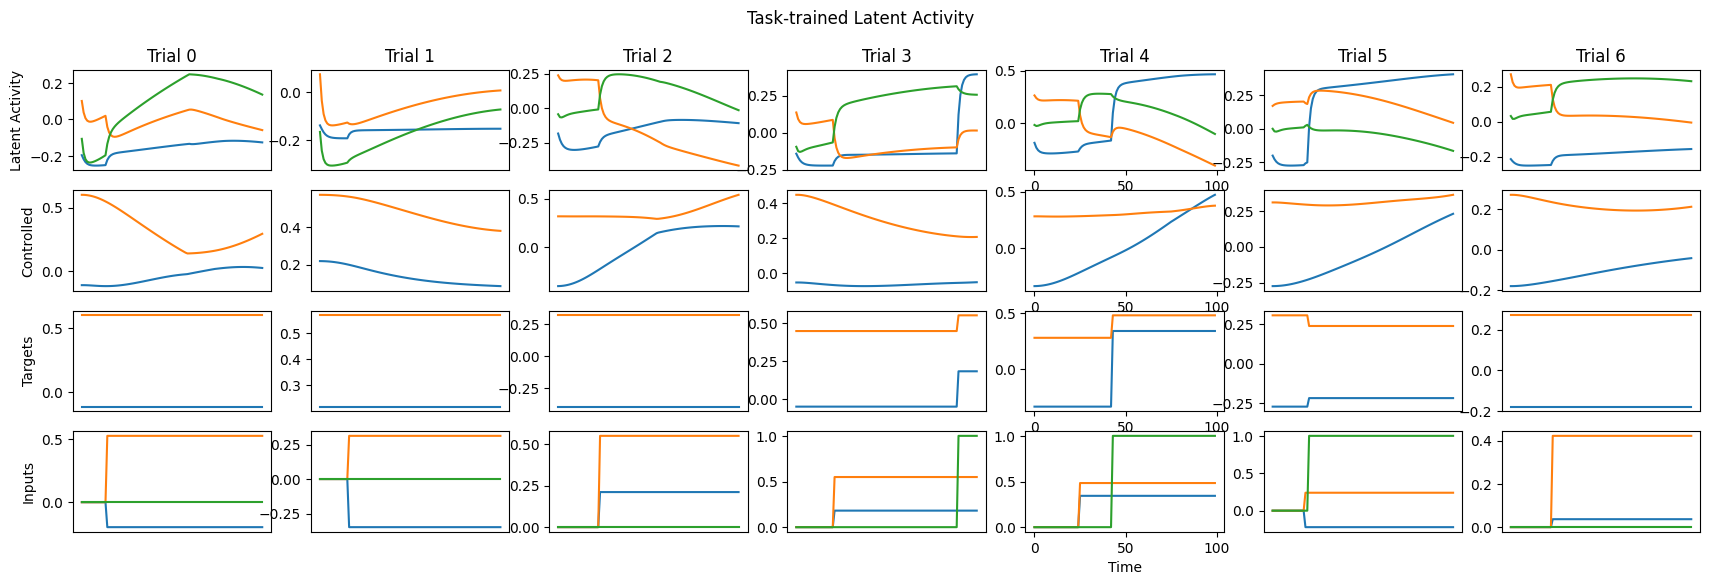

In [189]:
#plot baseline no force field result:
from ctd.comparison.analysis.tt.tt import Analysis_TT

model_home_path="/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/"
fpath_GRU_128 = model_home_path + "models_randtarg10_noforcefield/"
# Create the analysis object:
analysis_GRU_128_noforce = Analysis_TT(
    run_name = "GRU_128_3bff",
    filepath = fpath_GRU_128)

analysis_GRU_128_noforce.plot_trial_io(num_trials = 7)

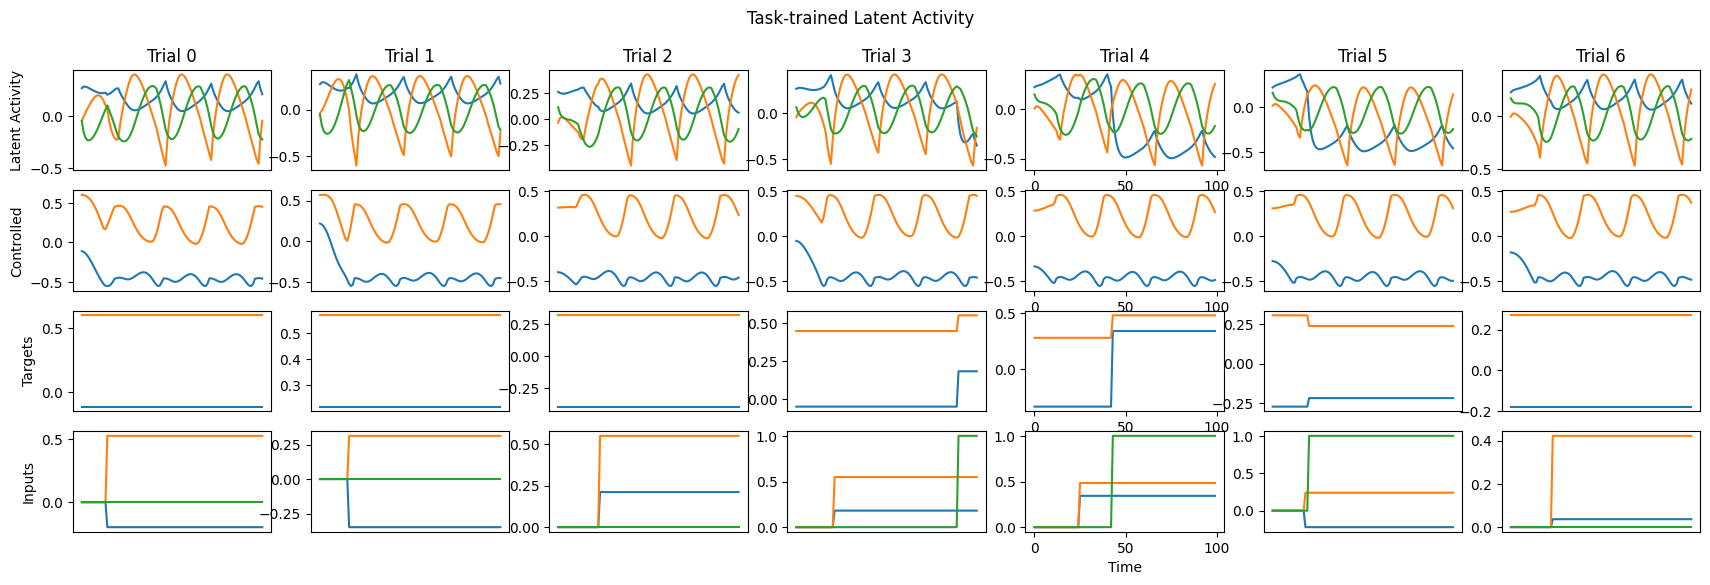

In [202]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

model_home_path="/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/"
fpath_GRU_128 = model_home_path + "models_randtarg10_forcefield/"
# Create the analysis object:
analysis_GRU_128_forced = Analysis_TT(
    run_name = "GRU_128_3bff",
    filepath = fpath_GRU_128)

analysis_GRU_128_forced.plot_trial_io(num_trials = 7)

In [184]:
help(analysis_GRU_128_forced)

Help on Analysis_TT in module ctd.comparison.analysis.tt.tt object:

class Analysis_TT(ctd.comparison.analysis.analysis.Analysis)
 |  Analysis_TT(run_name, filepath, use_train_dm=False)
 |  
 |  Method resolution order:
 |      Analysis_TT
 |      ctd.comparison.analysis.analysis.Analysis
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, run_name, filepath, use_train_dm=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compute_FPs(self, noiseless=True, inputs=None, n_inits=1024, noise_scale=0.0, learning_rate=0.001, max_iters=10000, device='cpu', seed=0, compute_jacobians=True)
 |  
 |  find_DSA_hps(self, rank_sweep=[10, 20], delay_sweep=[1, 5])
 |  
 |  get_extra_inputs(self, phase='all')
 |  
 |  get_inputs(self, phase='all')
 |  
 |  get_inputs_to_env(self, phase='all')
 |  
 |  get_latents(self, phase='all')
 |  
 |  get_latents_noiseless(self, phase='all')
 |  
 |  get_latents_pca(self, num_PCs=3)
 |  
 |  get_model

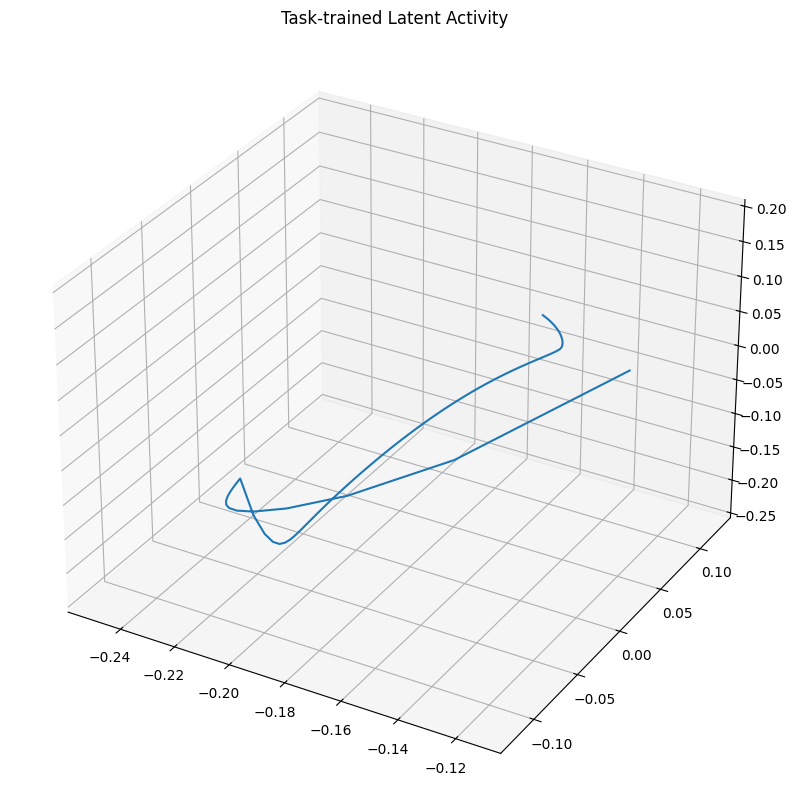

In [191]:
analysis_GRU_128_noforce.plot_trial_latents(num_trials=1)

In [26]:
xxx=rt_task_env_force_field.generate_dataset(n_samples=10)

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_71243/204141334.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_71243/204141334.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_71243/204141334.py:118: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdo

In [37]:
xxx[0]["inputs_to_env"][1,1,:]

array([100000.,      0.])

In [46]:
rt_task_env_force_field.step(torch.tensor([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]), deterministic=False)

(tensor([[ 0.3817,  0.3653,  1.1553,  0.8814,  0.9994,  0.8045,  1.0588,  0.5505,
           0.0220, -0.0220, -0.0547,  0.0463, -0.0467,  0.0306]]),
 None,
 False,
 False,
 {'states': {'joint': tensor([[ 0.1330,  1.2093, -1.9396,  6.1536]]),
   'cartesian': tensor([[ 0.3817,  0.3653, -1.2873, -0.2761]]),
   'muscle': tensor([[[ 6.4844e-01,  6.4844e-01,  6.4844e-01,  6.4844e-01,  6.4844e-01,
              6.4844e-01],
            [ 1.5481e-01,  1.2339e-01,  9.1945e-02,  7.4823e-02,  1.4506e-01,
              6.9910e-02],
            [ 3.2975e-02, -3.2975e-02, -8.2005e-02,  6.9524e-02, -7.0036e-02,
              4.5843e-02],
            [ 4.5053e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.4492e-03,
              0.0000e+00],
            [ 8.6607e-01,  9.1535e-01,  1.0000e+00,  8.0688e-01,  9.8078e-01,
              3.5474e-02],
            [ 1.0416e+00,  9.5652e-01,  8.9365e-01,  1.0820e+00,  9.0880e-01,
              1.0565e+00],
            [ 5.2793e+02,  6.8526e+02,  8.2401e+02,  8

In [19]:
rt_task_env_force_field_big= RandomTarget_forcefield(effector = RigidTendonArm26(muscle = MujocoHillMuscle()),force_field=np.array([[-100,10]]))

force field is [[-100   10]]


In [158]:
force_field_tensor = torch.tensor(rt_task_env_force_field_big.force_field, dtype=torch.float32)
positions=[]
for i in range(1,500):
    rt_task_env_force_field_big.step(
        torch.tensor([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]), 
        deterministic=True)
    positions.append(rt_task_env_force_field_big.effector.joint2cartesian(rt_task_env_force_field_big.effector.states["joint"]).chunk(2, dim=-1)[0].detach().cpu().numpy())


In [144]:
positions

[array([[0.3831341 , 0.50042516]], dtype=float32),
 array([[0.38217944, 0.50061   ]], dtype=float32),
 array([[0.37620077, 0.50119317]], dtype=float32),
 array([[0.36556378, 0.50138474]], dtype=float32),
 array([[0.35057974, 0.50026226]], dtype=float32),
 array([[0.33156872, 0.49694604]], dtype=float32),
 array([[0.30903423, 0.4907735 ]], dtype=float32),
 array([[0.2836645 , 0.48139095]], dtype=float32),
 array([[0.25623617, 0.4687327 ]], dtype=float32),
 array([[0.22750601, 0.45292506]], dtype=float32),
 array([[0.19811842, 0.43415222]], dtype=float32),
 array([[0.16854358, 0.41251302]], dtype=float32),
 array([[0.13917166, 0.38801438]], dtype=float32),
 array([[0.11041482, 0.3606285 ]], dtype=float32),
 array([[0.08274922, 0.33033645]], dtype=float32),
 array([[0.05672756, 0.29715678]], dtype=float32),
 array([[0.03300387, 0.26122862]], dtype=float32),
 array([[0.01232257, 0.22291785]], dtype=float32),
 array([[-0.00458813,  0.1827991 ]], dtype=float32),
 array([[-0.01713443,  0.1415

In [61]:
np.vstack(positions).shape

(99, 2)

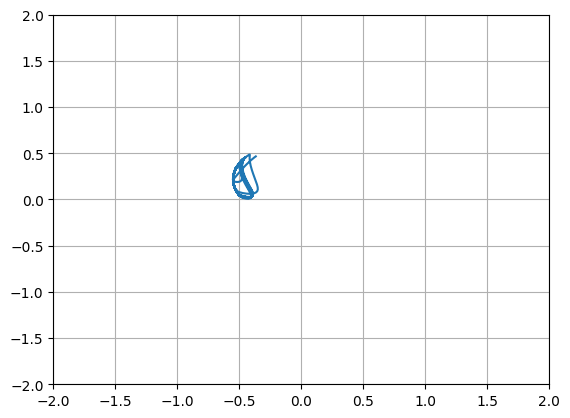

In [159]:
import matplotlib.pyplot as plt
plt.plot(np.vstack(positions)[:,0], np.vstack(positions)[:,1])
#set x and y limits to -2, 2
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)

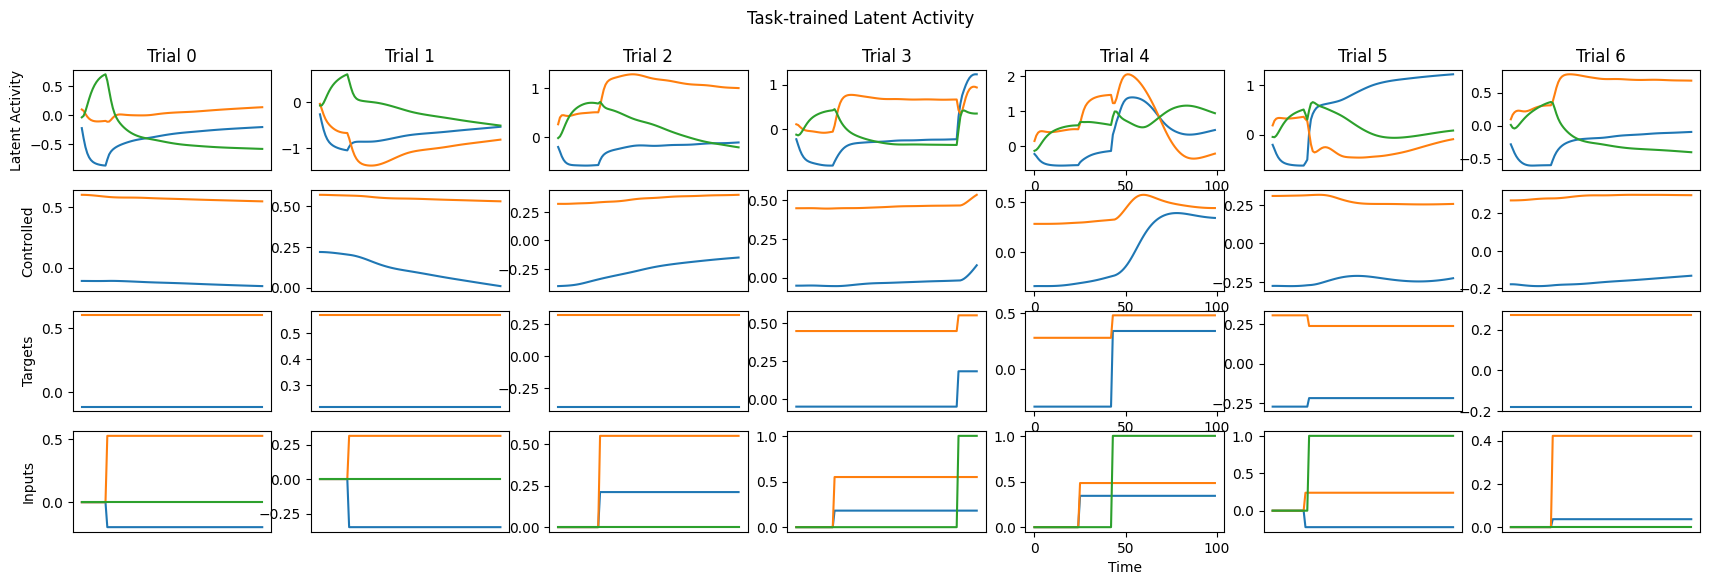

In [26]:
#LOADING FROM RUNS ON HPC:
#plot baseline no force field result:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

model_home_path="/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/"
fpath_GRU_128 = model_home_path + "models_randtarg500_noforcefield/"
# Create the analysis object:
analysis_GRU_128_noforce = TT_RandomTarget(
    run_name = "GRU_128_3bff",
    filepath = fpath_GRU_128)

analysis_GRU_128_noforce.plot_trial_io(num_trials = 7)

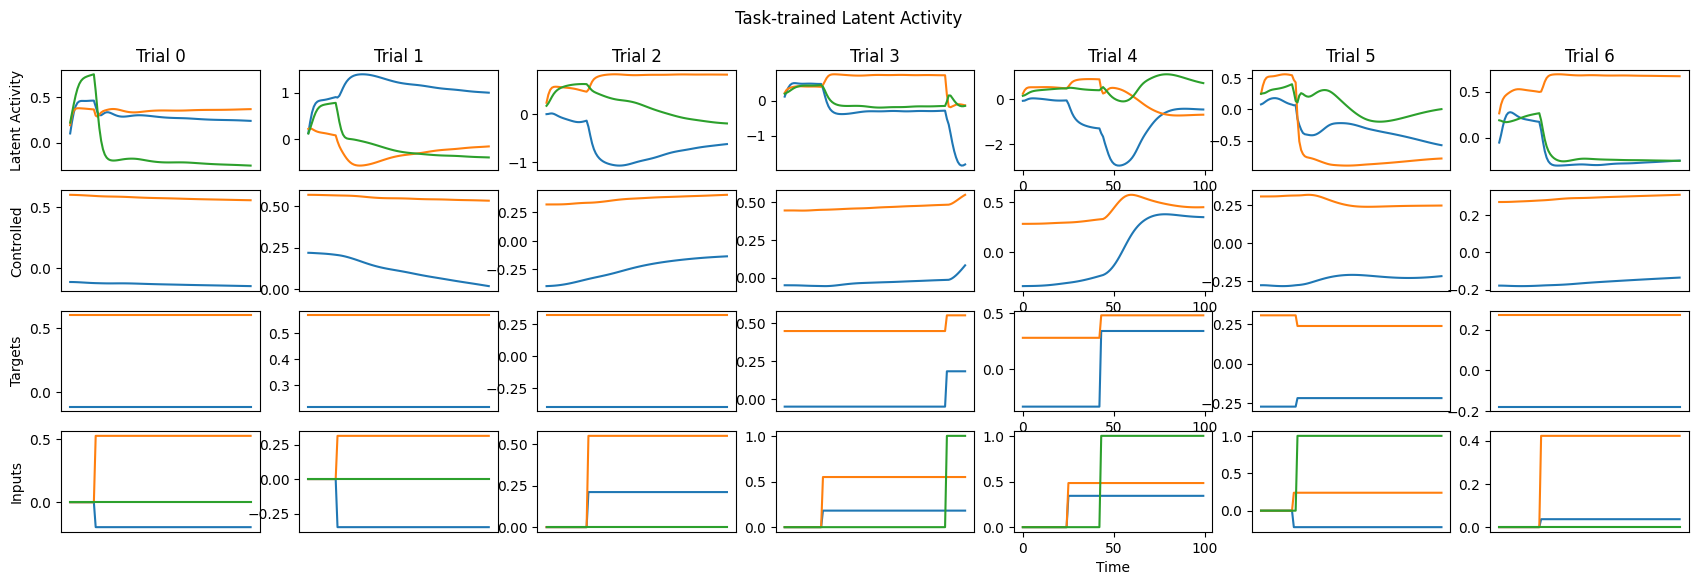

In [23]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget
fpath_GRU_128 = model_home_path + "models_randtarg500_forcefield_x-1.0_y0.0/"
# Create the analysis object:
analysis_GRU_128_forcefield = TT_RandomTarget(
    run_name = "GRU_128_3bff",
    filepath = fpath_GRU_128)

analysis_GRU_128_forcefield.plot_trial_io(num_trials = 7)

/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:41: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  pre_ind = pre_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:42: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  post_ind = post_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/On

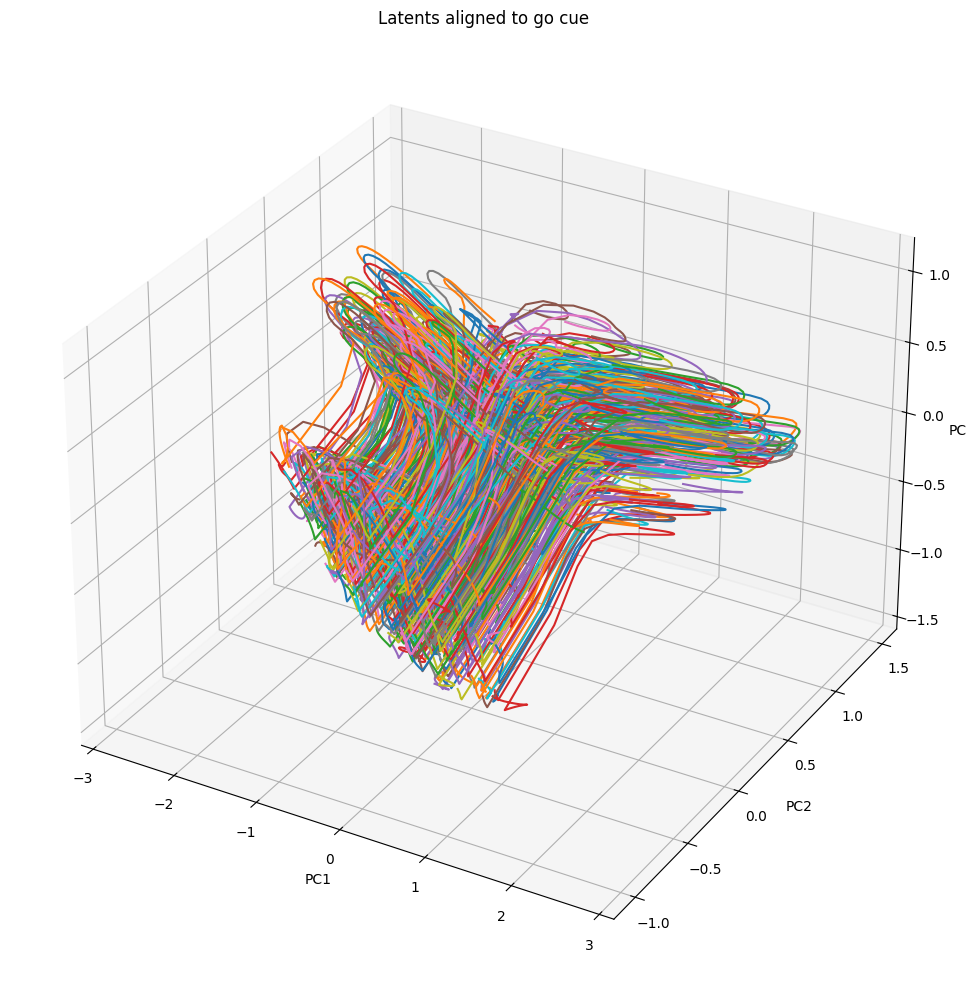

In [28]:
analysis_GRU_128_noforce.plot_latents_aligned()

/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:41: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  pre_ind = pre_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:42: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  post_ind = post_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/On

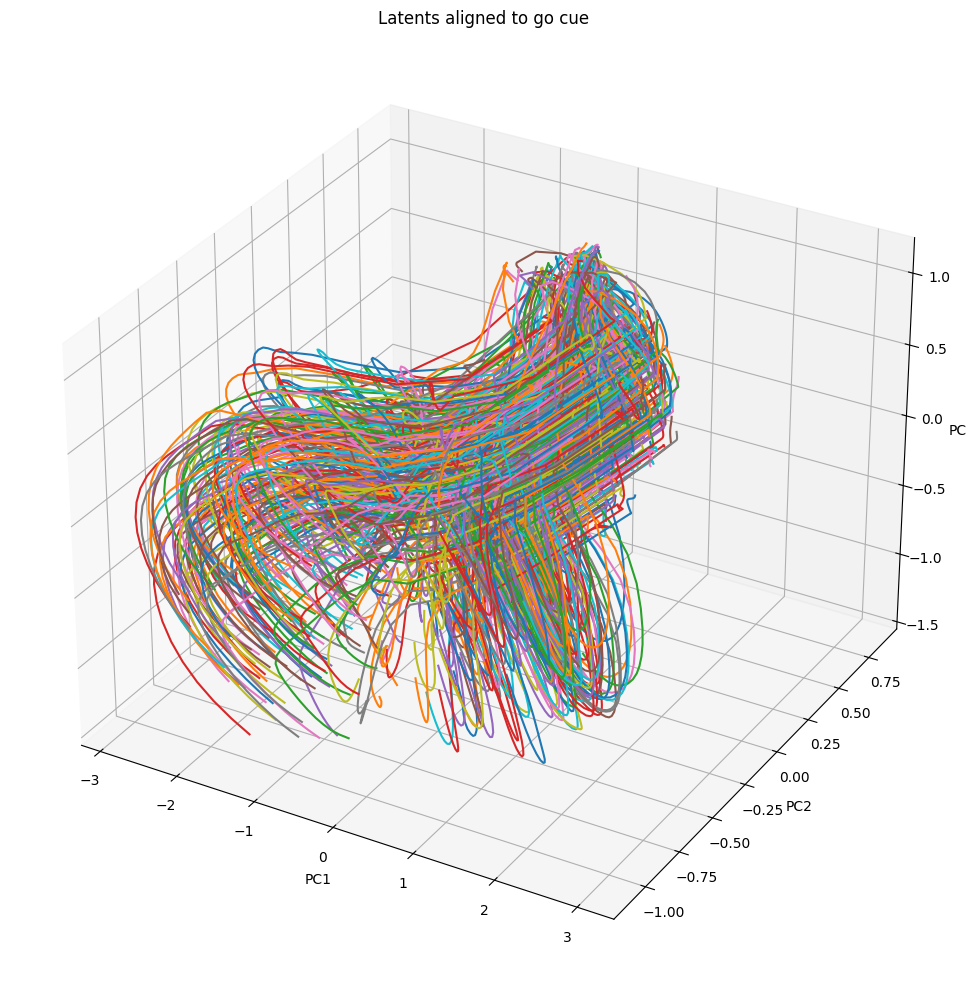

In [25]:
analysis_GRU_128_forcefield.plot_latents_aligned()

/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:93: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  pre_ind = pre_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/ComputationThruDynamicsBenchmark/ctd/comparison/analysis/tt/tasks/tt_RandomTarget.py:94: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  post_ind = post_ind[lats_flag].detach().numpy().astype(int)
/Users/as15635/Library/CloudStorage/On

Writing frame 0 of 40
Writing frame 1 of 40
Writing frame 2 of 40
Writing frame 3 of 40
Writing frame 4 of 40
Writing frame 5 of 40
Writing frame 6 of 40
Writing frame 7 of 40
Writing frame 8 of 40
Writing frame 9 of 40
Writing frame 10 of 40
Writing frame 11 of 40
Writing frame 12 of 40
Writing frame 13 of 40
Writing frame 14 of 40
Writing frame 15 of 40
Writing frame 16 of 40
Writing frame 17 of 40
Writing frame 18 of 40
Writing frame 19 of 40
Writing frame 20 of 40
Writing frame 21 of 40
Writing frame 22 of 40
Writing frame 23 of 40
Writing frame 24 of 40
Writing frame 25 of 40
Writing frame 26 of 40
Writing frame 27 of 40
Writing frame 28 of 40
Writing frame 29 of 40
Writing frame 30 of 40
Writing frame 31 of 40
Writing frame 32 of 40
Writing frame 33 of 40
Writing frame 34 of 40
Writing frame 35 of 40
Writing frame 36 of 40
Writing frame 37 of 40
Writing frame 38 of 40
Writing frame 39 of 40


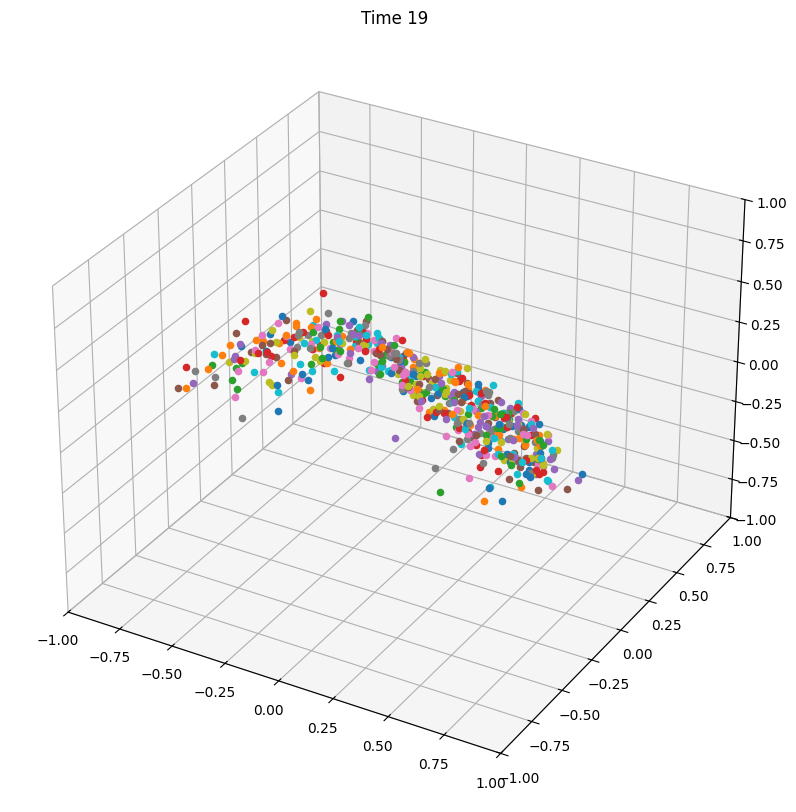

In [33]:
analysis_GRU_128_forcefield.plot_latents_aligned_video()

In [22]:
#test model trained on no force field on force field task:
from ctd.task_modeling.datamodule.samplers import RandomSampler
rs=RandomSampler(
    rt_task_env_force_field_big,
    10
)

TypeError: object of type 'RandomTarget_forcefield' has no len()

In [ ]:
import logging
import os
import pickle

import dotenv
import h5py
import numpy as np
import pytorch_lightning as pl
import torch
from gymnasium import Env
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from ctd.task_modeling.datamodule.samplers import RandomSampler, SequentialSampler

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")


def save_dict_to_pickle(dic, filename):
    """
    Save a dictionary to a pickle file.
    """
    with open(filename, "wb") as f:
        pickle.dump(dic, f, pickle.HIGHEST_PROTOCOL)


def load_dict_from_pickle(filename):
    """
    Load a dictionary from a pickle file.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


logger = logging.getLogger(__name__)


def to_tensor(array):
    return torch.tensor(array, dtype=torch.float)


class TaskDataModule_andrew(pl.LightningDataModule):
    """Data module for task training and testing"""

    def __init__(
        self,
        data_env: Env = None,
        n_samples: int = 2000,
        seed: int = 0,
        batch_size: int = 64,
        num_workers: int = 4,
    ):
        """Initialize the data module
        Args:
            data_env (Env): The environment to simulate
            n_samples (int): The number of samples (trials) to simulate
            seed (int): The random seed to use
            batch_size (int): The batch size
            num_workers (int): The number of workers to use for data loading

        """
        super().__init__()
        self.save_hyperparameters()
        # Generate the dataset tag
        self.data_env = data_env
        self.name = None
        self.input_labels = None
        self.output_labels = None
        self.for_sim = False
        if data_env is not None:
            self.set_environment(data_env)

    def set_environment(self, data_env, for_sim=False):
        """Set the environment for the data module"""
        self.data_env = data_env

        self.name = (
            f"{data_env.dataset_name}_{self.hparams.n_samples}S_{data_env.n_timesteps}T"
            f"_{self.hparams.seed}seed"
        )
        # if data_env has a noise parameter, add it to the name
        if hasattr(data_env, "noise"):
            self.name += f"_{data_env.noise}"

        # Set input/output labels according to the data environment
        self.input_labels = self.data_env.input_labels
        self.output_labels = self.data_env.output_labels
        self.for_sim = for_sim
        # Set extra data if it exists
        if hasattr(self.data_env, "extra"):
            self.extra = self.data_env.extra

        # If the environment has a specific sampling function, use it
        if hasattr(self.data_env, "sampler"):
            self.sampler_func = data_env.sampler
            self.val_sampler_func = SequentialSampler
        else:  # otherwise use the default samplers
            self.sampler_func = RandomSampler
            self.val_sampler_func = SequentialSampler

    def prepare_data(self):
        """Prepare the data for task-training

        All task-environments must have a generate_dataset method,
        called by prepare_data. This method returns a dictionary
        with the following mandatory keys:
            inputs: The inputs to the model
                (e.g., RNN inputs)
            inputs_to_env: The inputs to the environment
                (e.g., MotorNet bumps)
            targets: The targets for the model
                (e.g., the outputs of the environment or MotorNet goal)
            ics: The initial conditions for the environment
                (e.g., the starting joint state for MotorNet)
            conds: The condition of each trial
                (e.g., which task in MultiTask)
            extra: Any extra data that is needed for training
                (e.g., trial length for MultiTask)
        """
        hps = self.hparams

        if self.for_sim:
            sub_dir = "sim"
        else:
            sub_dir = "tt"
        fdir = os.path.join(HOME_DIR, "content", "datasets", sub_dir)
        if not os.path.exists(fdir):
            os.makedirs(fdir, exist_ok=True)
        fpath = os.path.join(
            HOME_DIR, "content", "datasets", sub_dir, f"{self.name}.h5"
        )
        fpath_pkl = os.path.join(
            HOME_DIR, "content", "datasets", sub_dir, f"{self.name}.pkl"
        )

        # Check if the dataset already exists, and if so, load it
        if os.path.isfile(fpath) and os.path.isfile(fpath_pkl):
            logger.info(f"Loading dataset {self.name}")
            return
        logger.info(f"Generating dataset {self.name}")

        # Simulate the task
        dataset_dict, extra_dict = self.data_env.generate_dataset(
            self.hparams.n_samples
        )

        # Extract the inputs, outputs, and initial conditions
        inputs_ds = dataset_dict["inputs"]
        inputs_to_env_ds = dataset_dict["inputs_to_env"]
        targets_ds = dataset_dict["targets"]
        ics_ds = dataset_dict["ics"]
        conds_ds = dataset_dict["conds"]
        extra_ds = dataset_dict["extra"]
        true_inputs_ds = dataset_dict["true_inputs"]

        # Perform data splits
        num_trials = ics_ds.shape[0]
        inds = np.arange(num_trials)
        train_inds, valid_inds = train_test_split(
            inds, test_size=0.2, random_state=hps.seed
        )

        # Save the data used to train the model
        with h5py.File(fpath, "w") as h5file:
            h5file.create_dataset("train_ics", data=ics_ds[train_inds])
            h5file.create_dataset("valid_ics", data=ics_ds[valid_inds])

            h5file.create_dataset("train_inputs", data=inputs_ds[train_inds])
            h5file.create_dataset("valid_inputs", data=inputs_ds[valid_inds])

            h5file.create_dataset(
                "train_inputs_to_env", data=inputs_to_env_ds[train_inds]
            )
            h5file.create_dataset(
                "valid_inputs_to_env", data=inputs_to_env_ds[valid_inds]
            )

            h5file.create_dataset("train_targets", data=targets_ds[train_inds])
            h5file.create_dataset("valid_targets", data=targets_ds[valid_inds])

            h5file.create_dataset("train_conds", data=conds_ds[train_inds])
            h5file.create_dataset("valid_conds", data=conds_ds[valid_inds])

            h5file.create_dataset("train_inds", data=train_inds)
            h5file.create_dataset("valid_inds", data=valid_inds)

            h5file.create_dataset("train_extra", data=extra_ds[train_inds])
            h5file.create_dataset("valid_extra", data=extra_ds[valid_inds])

            h5file.create_dataset("train_true_inputs", data=true_inputs_ds[train_inds])
            h5file.create_dataset("valid_true_inputs", data=true_inputs_ds[valid_inds])

        # Save extra information for plotting, offline analyses etc.
        save_dict_to_pickle(extra_dict, fpath_pkl)

    def setup(self, stage=None):
        # Load data arrays from file
        if self.for_sim:
            data_path = os.path.join(
                HOME_DIR, "content", "datasets", "sim", f"{self.name}.h5"
            )
            data_path_pkl = os.path.join(
                HOME_DIR, "content", "datasets", "sim", f"{self.name}.pkl"
            )
        else:
            data_path = os.path.join(
                HOME_DIR, "content", "datasets", "tt", f"{self.name}.h5"
            )
            data_path_pkl = os.path.join(
                HOME_DIR, "content", "datasets", "tt", f"{self.name}.pkl"
            )

        with h5py.File(data_path, "r") as h5file:
            train_ics = to_tensor(h5file["train_ics"][()])
            valid_ics = to_tensor(h5file["valid_ics"][()])

            train_inputs = to_tensor(h5file["train_inputs"][()])
            valid_inputs = to_tensor(h5file["valid_inputs"][()])

            train_inputs_to_env = to_tensor(h5file["train_inputs_to_env"][()])
            valid_inputs_to_env = to_tensor(h5file["valid_inputs_to_env"][()])

            train_targets = to_tensor(h5file["train_targets"][()])
            valid_targets = to_tensor(h5file["valid_targets"][()])

            train_conds = to_tensor(h5file["train_conds"][()])
            valid_conds = to_tensor(h5file["valid_conds"][()])

            # Load the indices
            train_inds = to_tensor(h5file["train_inds"][()])
            valid_inds = to_tensor(h5file["valid_inds"][()])
            # test_inds = to_tensor(h5file["test_inds"][()])

            train_extra = to_tensor(h5file["train_extra"][()])
            valid_extra = to_tensor(h5file["valid_extra"][()])

            train_true_inputs = to_tensor(h5file["train_true_inputs"][()])
            valid_true_inputs = to_tensor(h5file["valid_true_inputs"][()])

        self.extra_data = load_dict_from_pickle(data_path_pkl)

        # Store datasets
        self.train_ds = TensorDataset(
            train_ics,
            train_inputs,
            train_targets,
            train_inds,
            train_conds,
            train_extra,
            train_inputs_to_env,
            train_true_inputs,
        )

        self.valid_ds = TensorDataset(
            valid_ics,
            valid_inputs,
            valid_targets,
            valid_inds,
            valid_conds,
            valid_extra,
            valid_inputs_to_env,
            valid_true_inputs,
        )

        self.train_sampler = self.sampler_func(
            data_source=self.train_ds, num_samples=self.hparams.batch_size
        )
        self.valid_sampler = self.val_sampler_func(
            data_source=self.valid_ds, num_samples=self.hparams.batch_size
        )

    def train_dataloader(self, shuffle=True):
        train_dl = DataLoader(
            self.train_ds,
            batch_sampler=self.train_sampler,
            # batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            # shuffle=shuffle,
        )
        return train_dl

    def val_dataloader(self):
        valid_dl = DataLoader(
            self.valid_ds,
            batch_sampler=self.valid_sampler,
            # batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )
        return valid_dl
    
    def test_dataloader(self):
        test_dl = DataLoader(
            self.test_ds,
            batch_sampler=self.test_sampler,
            # batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )
        return test_dl


In [38]:
# Create a new analysis object with the test environment
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget
import pickle
import torch
from ctd.task_modeling.datamodule.samplers import RandomSampler

# Load your pretrained model
model_path = "models_randtarg500_noforcefield/model.pkl"
with open(model_path, "rb") as f:
    pretrained_task_wrapper = pickle.load(f)

# Create your test environment (force field)
test_env = RandomTarget_forcefield(
    effector=RigidTendonArm26(muscle=MujocoHillMuscle()),
    force_field=np.array([[-100, 10]])
)

task_datamodule = TaskDataModule(test_env, n_samples=100, batch_size=32)

force field is [[-100   10]]


In [71]:
yy=task_datamodule.test_dataloader()

MisconfigurationException: `test_dataloader` must be implemented to be used with the Lightning Trainer

In [73]:
task_datamodule.input_labels

['TargetX', 'TargetY', 'GoCue']

In [41]:
task_datamodule.setup()

In [42]:
dl=task_datamodule.val_dataloader()

In [67]:
dl.__dict__

{'dataset': <torch.utils.data.dataset.TensorDataset at 0x303589f50>,
 'num_workers': 4,
 'prefetch_factor': 2,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 'in_order': True,
 '_dataset_kind': 0,
 'batch_size': None,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x317305090>,
 'batch_sampler': <ctd.task_modeling.datamodule.samplers.SequentialSampler at 0x3037bbed0>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [69]:
print(dl.batch_size)

None


In [45]:
help(dl)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+_T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, collections.abc.Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[list], collections.abc.Iterable[list], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[list[~_T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '', in_order: bool = True)
 |  
 |  Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 

In [57]:
dl.dataset[0]

(tensor([2.3088, 1.7439, 0.0000, 0.0000]),
 tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
       

In [58]:
# Sample from the validation dataloader
batch = next(iter(dl))

print("Batch contents:")
for key, value in batch.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    else:
        print(f"  {key}: {type(value)}")

# Extract specific data
inputs = batch['inputs']  # Model inputs
targets = batch['targets']  # Target trajectories
env_inputs = batch['inputs_to_env']  # Environmental inputs (including force field)

print(f"\nInput shape: {inputs.shape}")  # Should be (batch_size, time_steps, input_features)
print(f"Target shape: {targets.shape}")  # Should be (batch_size, time_steps, output_features)
print(f"Env inputs shape: {env_inputs.shape}")  # Should be (batch_size, time_steps, 2) for 2D forces

Batch contents:


AttributeError: 'list' object has no attribute 'items'

In [86]:
#testing non force field model on force field environment:

# rt_task_env_force_field = RandomTarget_forcefield(effector = RigidTendonArm26(muscle = MujocoHillMuscle()),force_field=np.array([[-10,0]]))

# Step 2: Instantiate the task environment
# task_env = rt_task_env_force_field
task_env=RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))
# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: load pretrained model from pickle file:
import pathlib
import pickle
with open("models_randtarg500_noforcefield/model.pkl", "rb") as f:
    rnn = pickle.load(f).model


# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
trainer = Trainer(accelerator= "cpu",max_epochs=10,enable_progress_bar=True)
task_datamodule.setup(stage="val")
# Step 8: Fit the model
trainer.validate(task_wrapper, task_datamodule)

# save_dir = pathlib.Path(HOME_DIR) / "models_randtarg10_forcefield"
# save_dir.mkdir(exist_ok=True)
# with open(save_dir / "model.pkl", "wb") as f:
#     pickle.dump(task_wrapper, f)

# # save datamodule as .pkl
# with open(save_dir / "datamodule_sim.pkl", "wb") as f:
#     pickle.dump(task_datamodule, f)

/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Validation: |          | 0/? [00:00<?, ?it/s]

NaN or Inf found in input tensor.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       valid/loss                   nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid/loss': nan}]

In [62]:
xxx=[i  for i in dl]

In [66]:
len(xxx[0][0])

20

In [59]:
# Load both models and compare
def compare_models_on_force_field():
    # Load no-force model
    with open("models_randtarg500_noforcefield/model.pkl", "rb") as f:
        model_no_force = pickle.load(f)
    
    # Load force-field model  
    with open("models_randtarg500_forcefield_x-1.0_y0.0/model.pkl", "rb") as f:
        model_force_field = pickle.load(f)
    
    # Test both on force field data
    models = {'No Force Field': model_no_force, 'Force Field': model_force_field}
    results = {}
    
    for name, model in models.items():
        model.eval()
        losses = []
        
        with torch.no_grad():
            for batch in dl:
                inputs = batch['inputs']
                targets = batch['targets']
                env_inputs = batch['inputs_to_env']
                ics = batch['ics']
                
                outputs = model.forward_env(
                    inputs=inputs, ics=ics, env_inputs=env_inputs
                )
                loss = model.loss_func(outputs, targets)
                losses.append(loss.item())
        
        results[name] = {
            'mean_loss': np.mean(losses),
            'std_loss': np.std(losses),
            'losses': losses
        }
        print(f"{name}: Mean Loss = {results[name]['mean_loss']:.4f} ± {results[name]['std_loss']:.4f}")
    
    return results

comparison_results = compare_models_on_force_field()

TypeError: list indices must be integers or slices, not str

In [74]:
help(analysis_GRU_128_noforce)

Help on TT_RandomTarget in module ctd.comparison.analysis.tt.tasks.tt_RandomTarget object:

class TT_RandomTarget(ctd.comparison.analysis.tt.tt.Analysis_TT)
 |  TT_RandomTarget(run_name, filepath)
 |  
 |  Method resolution order:
 |      TT_RandomTarget
 |      ctd.comparison.analysis.tt.tt.Analysis_TT
 |      ctd.comparison.analysis.analysis.Analysis
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, run_name, filepath)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compute_coupled_FPs(self, noiseless=True, inputs=None, n_inits=1024, noise_scale=0.0, learning_rate=0.001, max_iters=10000, device='cpu', seed=0, compute_jacobians=False)
 |  
 |  generate_latent_video(self, align_to='go_cue', dims_by='target', color_by='target', pre_window=10, post_window=10, fps=10)
 |  
 |  plot_latents_aligned(self, align_to='go_cue', pre_align=20, post_align=20)
 |  
 |  plot_latents_aligned_video(self, align_to='go_cue', pre_align=20, post

In [85]:
import torch
import numpy as np

# Load pretrained model
with open("models_randtarg500_noforcefield/model.pkl", "rb") as f:
    pretrained_model = pickle.load(f)

# Create force field test environment  
test_env = RandomTarget_forcefield(
    effector=RigidTendonArm26(muscle=MujocoHillMuscle()),
    force_field=np.array([[-1.0, 0.0]])  # Use same force as your trained model
)

# Create test datamodule
test_datamodule = TaskDataModule(test_env, n_samples=100, batch_size=32)
test_datamodule.prepare_data()
test_datamodule.setup()

# Get test dataloader
test_dl = test_datamodule.val_dataloader()

# Test the model
pretrained_model.eval()
test_losses = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dl):
        try:
            # Unpack batch properly
            ics, inputs, targets, inds, conds, extra, inputs_to_env, true_inputs = batch
            
            # Check for NaN/inf in inputs
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print(f"NaN/Inf found in inputs at batch {batch_idx}")
                continue
                
            if torch.isnan(targets).any() or torch.isinf(targets).any():
                print(f"NaN/Inf found in targets at batch {batch_idx}")
                continue
            
            # Forward pass
            outputs = pretrained_model.forward_env(
                inputs=inputs,
                ics=ics,
                env_inputs=inputs_to_env
            )
            
            # Check outputs
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                print(f"NaN/Inf in model outputs at batch {batch_idx}")
                continue
            
            # Calculate loss
            loss = pretrained_model.loss_func(outputs, targets)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"NaN/Inf loss at batch {batch_idx}")
                print(f"Output range: {outputs.min().item():.4f} to {outputs.max().item():.4f}")
                print(f"Target range: {targets.min().item():.4f} to {targets.max().item():.4f}")
                continue
                
            test_losses.append(loss.item())
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

if test_losses:
    print(f"Average test loss: {np.mean(test_losses):.4f}")
    print(f"Test loss std: {np.std(test_losses):.4f}")
else:
    print("No valid test losses computed!")

force field is [[-1.  0.]]
Error in batch 0: 'TaskTrainedWrapper' object has no attribute 'forward_env'
No valid test losses computed!


In [91]:
# Load saved model and datamodule
save_dir="/Users/as15635/Library/CloudStorage/OneDrive-UniversityofBristol/IAI_Year_Three/NeuromatchNeuroAIProject/NeuroMatch25/models_randtarg500_noforcefield"
# Step 2: Load the trained model (task wrapper that contains the RNN)
with open(f'{save_dir}/model.pkl', 'rb') as f:
    task_wrapper = pickle.load(f)
with open(f'{save_dir}/datamodule_sim.pkl', 'rb') as f:
    task_datamodule = pickle.load(f)

rttask_env = RandomTarget_forcefield(effector = RigidTendonArm26(muscle = MujocoHillMuscle()),force_field=np.array([[-100,10]]))

task_wrapper.eval()
model = task_wrapper.model


force field is [[-100   10]]


In [97]:
model

GRU_RNN(
  (cell): GRUCell(17, 128)
  (readout): Linear(in_features=128, out_features=6, bias=True)
)

In [102]:
len(obs[0])

14

In [110]:
rttask_env.generate_dataset(10)

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:129: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdo

({'ics': tensor([[ 2.2553,  2.1622,  0.0000,  0.0000],
          [-0.6612,  0.8910,  0.0000,  0.0000],
          [ 0.1388,  2.3901,  0.0000,  0.0000],
          [ 1.2771,  1.1269,  0.0000,  0.0000],
          [ 1.0209, -0.3375,  0.0000,  0.0000],
          [ 0.2801,  1.6526,  0.0000,  0.0000],
          [-0.6973,  0.9143,  0.0000,  0.0000],
          [-0.0961, -1.0440,  0.0000,  0.0000],
          [ 0.6785, -0.7773,  0.0000,  0.0000],
          [ 2.1416,  0.3796,  0.0000,  0.0000]], dtype=torch.float64),
  'inputs': array([[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.60206246,  0.08082692,  1.        ],
          [ 0.60206246,  0.08082692,  1.        ],
          [ 0.60206246,  0.08082692,  1.        ]],
  
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
  

In [108]:
rttask_env.generate_trial_info()

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)


{'ics_joint': tensor([2.6176, 1.9808, 0.0000, 0.0000], dtype=torch.float64),
 'ics_xy': tensor([[-0.3054, -0.1762]]),
 'goal': tensor([[-0.1897, -0.1433]])}

In [113]:
#generate 10 trials:
test_dataset=rttask_env.generate_dataset(10)
#pick on:
test_trial= test_dataset[0]
#extract inputs and targets:
inputs = test_trial["inputs"]
targets = test_trial["targets"]
ics = test_trial["ics"]
inputs_to_env = test_trial["inputs_to_env"]

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_9674/1224457331.py:129: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdo

In [114]:
inputs_to_env

array([[[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]],

       [[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]],

       [[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]],

       ...,

       [[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]],

       [[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]],

       [[-100.,   10.],
        [-100.,   10.],
        [-100.,   10.],
        ...,
        [-100.,   10.],
        [-100.,   10.],
        [-100.,   10.]]], shape=(10, 100, 2))

In [ ]:
#Courtesy of Elizaveta.
# TESTING
# Reset environment and get initial observation
obs, info = rttask_env.reset()
  # ensures proper input shape
done = False
trajectory = []

hidden = None  # initialize hidden state
trial_inputs=
while not done:
    #Feeds the current state into the model and gets the action output.
    input=rttask_env.context_inputs
    with torch.no_grad():
        action_tensor, hidden = model(obs, hidden)

    action_tensor = action_tensor[:, :rttask_env.action_space.shape[0]]
    action = action_tensor.cpu().numpy()

    if action.ndim == 1:
        action = action[np.newaxis, :]  # Ensure shape is (1, 6)
    #Ensures the action is shaped like (1, N) to match the environment’s expectations.
    obs, _, done, _, info = rttask_env.step(action)

    # 👇 update the trial_info so construct_input_vector works
    rttask_env.trial_info.update(info)
    obs_vector = trtask_env.+rttask_env.construct_input_vector(rttask_env.trial_info)

    trajectory.append({
        'obs': obs_vector.squeeze().detach().cpu().numpy(),
        'action': action.squeeze(),
        'goal': info['goal'].squeeze().cpu().numpy(),
        'fingertip': info['states']['fingertip'].squeeze().cpu().numpy(),
    })


RuntimeError: input has inconsistent input_size: got 14 expected 17

In [16]:
# forcefield class version:
from motornet.environment import Environment
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from torch import nn
from typing import Union, Optional, Any
from torch import Tensor
from numpy import ndarray
from ctd.task_modeling.task_env.loss_func import RandomTargetLoss
class RandomTarget_forcefield(Environment):
    """A reach to a random target from a random starting position with a delay period.

    Args:
        network: :class:`motornet.nets.layers.Network` object class or subclass.
        This is the network that will perform the task.

        name: `String`, the name of the task object instance.
        deriv_weight: `Float`, the weight of the muscle activation's derivative
        contribution to the default muscle L2 loss.

        force_field: 'np.array', the force field to apply to the effector, of same dimension as the skeleton space_dim. (2d in this case)
            example 1N force to the right: np.array([[1, 0]]).

        **kwargs: This is passed as-is to the parent :class:`Task` class.
    """

    def __init__(self, *args, **kwargs):
        #putting forcefield here so it isnt used as kwarg for parent class.
        self.force_field = kwargs.pop("force_field", np.array([[0, 0]]))
        print("force field is", self.force_field)
        super().__init__(*args, **kwargs)

        self.obs_noise[: self.skeleton.space_dim] = [
            0.0
        ] * self.skeleton.space_dim  # target info is noiseless

        self.dataset_name = "RandomTarget"
        self.n_timesteps = np.floor(self.max_ep_duration / self.effector.dt).astype(int)
        self.input_labels = ["TargetX", "TargetY", "GoCue"] #recieves three input streams, 
                                                            #target x and y specify desired location.
                                                            #go cue is a binary signal that indicates when the movement should start.
        self.output_labels = ["Pec", "Delt", "Brad", "TriLong", "Biceps", "TriLat"] #each muscle's activation is an output.
        self.context_inputs = spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32) #the three inputs, each range -2 to 2. 
        self.coupled_env = True
        self.state_label = "fingertip"

        pos_weight = kwargs.get("pos_weight", 1.0) #i think this is for the position loss,
        act_weight = kwargs.get("act_weight", 1.0) #and for the activation loss.

        self.bump_mag_low = kwargs.get("bump_mag_low", 5)
        self.bump_mag_high = kwargs.get("bump_mag_high", 10)

        # self.force_field = kwargs.get("force_field", np.array([[0, 0]]))

        self.loss_func = RandomTargetLoss(
            position_loss=nn.MSELoss(), pos_weight=pos_weight, act_weight=act_weight
        )

    def step(self, action, deterministic=False, **kwargs):
        # Add the force field to any existing endpoint_load
        force_field_tensor = torch.tensor(self.force_field, dtype=torch.float32).to(self.device)
        
        if 'endpoint_load' in kwargs:
            kwargs['endpoint_load'] = kwargs['endpoint_load'] + force_field_tensor
        else:
            kwargs['endpoint_load'] = force_field_tensor
        
        return super().step(action, deterministic=deterministic, **kwargs)

    def generate_dataset(self, n_samples):
        # Make target circular, change loss function to be pinned at zero
        initial_state = []
        inputs = np.zeros((n_samples, self.n_timesteps, 3))

        goal_list = []
        go_cue_list = []
        target_on_list = []
        catch_trials = []
        ext_inputs_list = []

        for i in range(n_samples):
            catch_trial = np.random.choice([0, 1], p=[0.8, 0.2])
            bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])
            move_bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])

            target_on = np.random.randint(10, 30)
            go_cue = np.random.randint(target_on, self.n_timesteps)
            if move_bump_trial:
                bump_time = np.random.randint(go_cue, go_cue + 40)
            else:
                bump_time = np.random.randint(0, self.n_timesteps - 30)
            bump_duration = np.random.randint(15, 30)
            bump_theta = np.random.uniform(0, 2 * np.pi)
            bump_mag = np.random.uniform(self.bump_mag_low, self.bump_mag_high)

            target_on_list.append(target_on)

            info = self.generate_trial_info()
            initial_state.append(info["ics_joint"])
            initial_state_xy = info["ics_xy"]


            #this is the environmental force field input. leave it set to zero for now so we can add the bump first.
            env_inputs_mat = np.zeros((self.n_timesteps, 2))

            #then it has the bump added.
            if bump_trial:
                bump_end = min(bump_time + bump_duration, self.n_timesteps)
                env_inputs_mat[bump_time:bump_end, :] = np.array(
                    [bump_mag * np.cos(bump_theta), bump_mag * np.sin(bump_theta)]
                )

            #we add the force field here, so it can then get loaded into the input_env as normal.
            env_inputs_mat += self.force_field[0,:]

            goal_matrix = torch.zeros((self.n_timesteps, self.skeleton.space_dim))
            if catch_trial:
                go_cue = -1
                goal_matrix[:, :] = initial_state_xy
            else:
                inputs[i, go_cue:, 2] = 1

                goal_matrix[:go_cue, :] = initial_state_xy
                goal_matrix[go_cue:, :] = torch.squeeze(info["goal"])

            go_cue_list.append(go_cue)
            inputs[i, target_on:, 0:2] = info["goal"]

            catch_trials.append(catch_trial)
            goal_list.append(goal_matrix)
            ext_inputs_list.append(env_inputs_mat)

        go_cue_list = np.array(go_cue_list)
        target_on_list = np.array(target_on_list)
        env_inputs = np.stack(ext_inputs_list, axis=0)
        extra = np.stack((target_on_list, go_cue_list), axis=1)
        conds = np.array(catch_trials)

        initial_state = torch.stack(initial_state, axis=0)
        goal_list = torch.stack(goal_list, axis=0)
        dataset_dict = {
            "ics": initial_state,
            "inputs": inputs,
            "inputs_to_env": env_inputs,
            "targets": goal_list,
            "conds": conds,
            "extra": extra,
            "true_inputs": inputs,
        }
        extra_dict = {}
        return dataset_dict, extra_dict

    def generate_trial_info(self):
        """
        Generate a trial for the task.
        This is a reach to a random target from a random starting
        position with a delay period.
        """
        sho_limit = [-90, 180]#[0, 135]  # mechanical constraints - used to be -90 180
        # sho_limit = [0, 135]  # mechanical constraints - used to be -90 180
        elb_limit = [-90, 180]#[0, 155]
        # elb_limit = [0, 155]
        sho_ang = np.deg2rad(np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30))
        elb_ang = np.deg2rad(np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30))

        sho_ang_targ = np.deg2rad(
            np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30)
        )
        elb_ang_targ = np.deg2rad(
            np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30)
        )

        angs = torch.tensor(np.array([sho_ang, elb_ang, 0, 0]))
        ang_targ = torch.tensor(np.array([sho_ang_targ, elb_ang_targ, 0, 0]))

        target_pos = self.joint2cartesian(
            torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        start_xy = self.joint2cartesian(
            torch.tensor(angs, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        info = dict(
            ics_joint=angs,
            ics_xy=start_xy,
            goal=target_pos,
        )
        return info

    def set_goal(
        self,
        goal: torch.Tensor,
    ):
        """
        Sets the goal of the task. This is the target position of the effector.
        """
        self.goal = goal

    def get_obs(self, action=None, deterministic: bool = False) -> Union[Tensor, ndarray]:
        self.update_obs_buffer(action=action)

        obs_as_list = [
            self.obs_buffer["vision"][0],
            self.obs_buffer["proprioception"][0],
        ] + self.obs_buffer["action"][: self.action_frame_stacking]

        obs = torch.cat(obs_as_list, dim=-1)

        if deterministic is False:
            obs = self.apply_noise(obs, noise=self.obs_noise)

        return obs if self.differentiable else self.detach(obs)

    def reset(
        self,
        batch_size: int = 1,
        options: Optional[dict[str, Any]] = None,
        seed: Optional[int] = None,
    ) -> tuple[Any, dict[str, Any]]:

        """
        Uses the :meth:`Environment.reset()` method of the parent class
        :class:`Environment` that can be overwritten to change the returned data.
        Here the goals (`i.e.`, the targets) are drawn from a random uniform
        distribution across the full joint space.
        """
        sho_limit = np.deg2rad([0, 135])  # mechanical constraints - used to be -90 180
        elb_limit = np.deg2rad([0, 155])
        # Make self.obs_noise a list
        self._set_generator(seed=seed)
        # if ic_state is in options, use that
        if options is not None and "deterministic" in options.keys():
            deterministic = options["deterministic"]
        else:
            deterministic = False
        if options is not None and "ic_state" in options.keys():
            ic_state_shape = np.shape(self.detach(options["ic_state"]))
            if ic_state_shape[0] > 1:
                batch_size = ic_state_shape[0]
            ic_state = options["ic_state"]
        else:
            ic_state = self.q_init

        if options is not None and "target_state" in options.keys():
            self.goal = options["target_state"]
        else:
            sho_ang = np.random.uniform(
                sho_limit[0] + 20, sho_limit[1] - 20, size=batch_size
            )
            elb_ang = np.random.uniform(
                elb_limit[0] + 20, elb_limit[1] - 20, size=batch_size
            )
            sho_vel = np.zeros(batch_size)
            elb_vel = np.zeros(batch_size)
            angs = np.stack((sho_ang, elb_ang, sho_vel, elb_vel), axis=1)
            self.goal = self.joint2cartesian(
                torch.tensor(angs, dtype=torch.float32, device=self.device)
            ).chunk(2, dim=-1)[0]

        options = {
            "batch_size": batch_size,
            "joint_state": ic_state,
        }
        self.effector.reset(options=options)

        self.elapsed = 0.0

        action = torch.zeros((batch_size, self.action_space.shape[0])).to(self.device)

        self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(
            self.obs_buffer["proprioception"]
        )
        self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
        self.obs_buffer["action"] = [action] * self.action_frame_stacking

        action = action if self.differentiable else self.detach(action)

        obs = self.get_obs(deterministic=deterministic)
        info = {
            "states": self._maybe_detach_states(),
            "action": action,
            "noisy action": action,
            "goal": self.goal if self.differentiable else self.detach(self.goal),
        }
        return obs, info


force field is [[-5.  5.]]
  ICS: tensor([[0.2898, 0.8076, 0.0000, 0.0000]], dtype=torch.float64)
Trial shapes:
  ICs: torch.Size([1, 4])
  Inputs: (1, 100, 3)
  Targets: torch.Size([1, 100, 2])
  Env inputs: (1, 100, 2)
100
Starting trial simulation...
Initial observation shape: torch.Size([1, 14])
Expected: (1, 14) -> vision(2) + proprioception(12)
Step 0: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 1: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 2: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 3: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 4: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 5: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.S

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_43225/3954230811.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_43225/3954230811.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_43225/3954230811.py:129: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/de

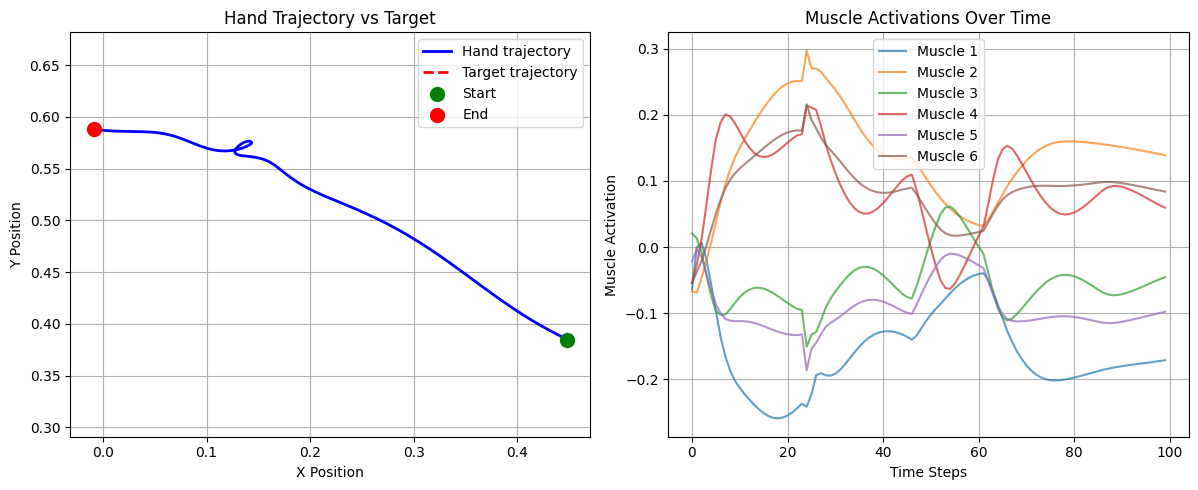


Performance Metrics:
Final position error: 0.5001
Mean position error: 0.3173


In [18]:
import torch
import numpy as np

# Load your pretrained model
with open("models_randtarg500_noforcefield/model.pkl", "rb") as f:
    pretrained_model = pickle.load(f)
    
model = pretrained_model.model
model.eval()

# Generate test trials
#change environment to centre out
test_env = RandomTarget_forcefield(
    effector=RigidTendonArm26(muscle=MujocoHillMuscle()),
    force_field=np.array([[-5.0, 5.0]])
)

# Generate a dataset with your trials
test_dataset = test_env.generate_dataset(n_samples=10)
trial_idx = 0  # Pick the first trial

# Extract trial data
ics = test_dataset[0]["ics"][trial_idx:trial_idx+1]  # Shape: (1, 4)
inputs = test_dataset[0]["inputs"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 3)
targets = test_dataset[0]["targets"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 2)
inputs_to_env = test_dataset[0]["inputs_to_env"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 2)

print(f"  ICS: {ics}")
print(f"Trial shapes:")
print(f"  ICs: {ics.shape}")
print(f"  Inputs: {inputs.shape}")
print(f"  Targets: {targets.shape}")
print(f"  Env inputs: {inputs_to_env.shape}")

# Reset environment with the trial's initial conditions
obs, info = test_env.reset(
    batch_size=1,
    options={"ic_state": ics, "deterministic": True}
)

n_timesteps = inputs.shape[1]
print(n_timesteps)
trajectory = []
hidden = None

print(f"Starting trial simulation...")
print(f"Initial observation shape: {obs.shape}")
print(f"Expected: (1, 14) -> vision(2) + proprioception(12)")

# Run the trial step by step
for t in range(n_timesteps):
    # Get current context inputs (TargetX, TargetY, GoCue)
    context_input = torch.tensor(inputs[0, t:t+1, :], dtype=torch.float32)  # Shape: (1, 3)
    
    # Combine observation with context inputs to get full model input
    full_input = torch.cat([obs, context_input], dim=-1)  # Shape: (1, 17)
    
    print(f"Step {t}: obs shape {obs.shape}, context shape {context_input.shape}, full input shape {full_input.shape}")
    
    # Forward pass through model
    with torch.no_grad():
        action_pred, hidden = model(full_input, hidden)
    
    # Extract muscle activations (first 6 outputs)
    muscle_activations = action_pred[:, :test_env.action_space.shape[0]]
    
    # Apply force field if needed (pass env inputs as endpoint_load)
    #try removing this line if not using force field
    env_force = torch.tensor(inputs_to_env[0, t:t+1, :], dtype=torch.float32)
    
    # Step the environment
    #also update this call to not use the endpoint load
    obs, _, done, _, info = test_env.step(
        muscle_activations, 
        deterministic=True,
        endpoint_load=env_force
    )
    
    # Store trajectory data
    trajectory.append({
        'timestep': t,
        'context_input': context_input.squeeze().cpu().numpy(),
        'observation': obs.squeeze().cpu().numpy(),
        'action': muscle_activations.squeeze().cpu().numpy(),
        'fingertip_pos': info['states']['fingertip'].squeeze().cpu().numpy(),
        'target_pos': targets[0, t, :].cpu().numpy(),
        'force_applied': env_force.squeeze().cpu().numpy()
    })
    
    if done:
        print(f"Trial ended at timestep {t}")
        break

print(f"Trial completed with {len(trajectory)} timesteps")

# Plot the results
import matplotlib.pyplot as plt

# Extract trajectory data for plotting
fingertip_positions = np.array([step['fingertip_pos'] for step in trajectory])
target_positions = np.array([step['target_pos'] for step in trajectory])
actions = np.array([step['action'] for step in trajectory])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot hand trajectory vs target
ax1.plot(fingertip_positions[:, 0], fingertip_positions[:, 1], 'b-', label='Hand trajectory', linewidth=2)
ax1.plot(target_positions[:, 0], target_positions[:, 1], 'r--', label='Target trajectory', linewidth=2)
ax1.scatter(fingertip_positions[0, 0], fingertip_positions[0, 1], c='green', s=100, label='Start', zorder=5)
ax1.scatter(fingertip_positions[-1, 0], fingertip_positions[-1, 1], c='red', s=100, label='End', zorder=5)
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_title('Hand Trajectory vs Target')
ax1.legend()
ax1.grid(True)
ax1.axis('equal')

# Plot muscle activations over time
for i in range(6):
    ax2.plot(actions[:, i], label=f'Muscle {i+1}', alpha=0.7)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Muscle Activation')
ax2.set_title('Muscle Activations Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate performance metrics
final_error = np.linalg.norm(fingertip_positions[-1] - target_positions[-1])
mean_error = np.mean([np.linalg.norm(fp - tp) for fp, tp in zip(fingertip_positions, target_positions)])

print(f"\nPerformance Metrics:")
print(f"Final position error: {final_error:.4f}")
print(f"Mean position error: {mean_error:.4f}")

Testing Elizaveta's centre out environment:

In [ ]:

import torch
import numpy as np
from itertools import combinations

from ctd.task_modeling.task_env.task_env import RandomTarget
import torch
import numpy as np
from itertools import combinations

class RandomTargetCenterOut(RandomTarget):

    def __init__(self, *args, **kwargs):
        self.input_components = ['ics_joint', 'goal', 'phase']  # <-- set something temporary
        super().__init__(*args, **kwargs)  # this calls reset()
        self.model = None
    def set_model(self, model):
        """Set model after init and determine matching input components."""
        self.model = model
        self._match_model_input()

    def _match_model_input(self):
        dummy = self.generate_trial_info()
        component_sizes = {k: v.numel() for k, v in dummy.items() if isinstance(v, torch.Tensor)}
        component_sizes['phase'] = 1  # Always include

        try:
            in_features = self.model.readout.in_features
        except AttributeError:
            in_features = self.model.input_size

        for r in range(1, len(component_sizes)+1):
            for combo in combinations(component_sizes, r):
                total = sum(component_sizes[k] for k in combo)
                if total == in_features:
                    self.input_components = list(combo)
                    print(f"[INFO] Auto-matched inputs: {self.input_components}")
                    return

        raise ValueError(f"No valid input combination found to match model input size {in_features}")
    
    def generate_trial_info(self):
        """
        Generate a trial for the task.
        This is a reach to a random target from a random starting
        position with a delay period.
        """
        sho_limit = [-180, 180]#[0, 135]  # mechanical constraints - used to be -90 180
        # sho_limit = [0, 135]  # mechanical constraints - used to be -90 180
        elb_limit = [-180, 180]#[0, 155]
        # elb_limit = [0, 155]
        sho_ang = np.deg2rad(np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30))
        elb_ang = np.deg2rad(np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30))

        sho_ang_targ = np.deg2rad(
            np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30)
        )
        elb_ang_targ = np.deg2rad(
            np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30)
        )
        sho_ang= np.deg2rad(90)
        elb_ang = np.deg2rad(180)
        angs = torch.tensor(np.array([sho_ang, elb_ang, 0, 0]))
        ang_targ = torch.tensor(np.array([sho_ang_targ, elb_ang_targ, 0, 0]))

        target_pos = self.joint2cartesian(
            torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        start_xy = self.joint2cartesian(
            torch.tensor(angs, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        info = dict(
            ics_joint=angs,
            ics_xy=start_xy,
            goal=target_pos,
        )
        return info

    # def generate_trial_info(self):
    #     sho_ang = np.deg2rad(90)
    #     elb_ang = np.deg2rad(90)
    #     radius = 0.2
    #     angle = np.random.uniform(0, 2 * np.pi)
    #     x = radius * np.cos(angle)
    #     y = radius * np.sin(angle)

    #     target_pos = torch.tensor([[x, y]], dtype=torch.float32, device=self.device)
    #     angs = torch.tensor([sho_ang, elb_ang, 0, 0], dtype=torch.float32, device=self.device)

    #     # Override starting position manually to (0, 0)
    #     start_xy = torch.tensor([[0.0, 0.0]], dtype=torch.float32, device=self.device)
    #     return dict(
    #         ics_joint=angs,
    #         ics_xy=start_xy,
    #         goal=target_pos
    #     )

    def construct_input_vector(self, obs_dict):
        if not hasattr(self, "input_components"):
            raise RuntimeError("`input_components` is not set. Did you forget to call `set_model()`?")
        vecs = []
        for key in self.input_components:
            if key == 'phase':
                vecs.append(torch.tensor([[0.0]], dtype=torch.float32, device=self.device))
            else:
                val = obs_dict[key]
                if val.ndim == 1:
                    val = val.unsqueeze(0)
                vecs.append(val)
        return torch.cat(vecs, dim=-1)
    
    def reset(
        self,
        batch_size: int = 1,
        options: Optional[dict[str, Any]] = None,
        seed: Optional[int] = None,
    ) -> tuple[Any, dict[str, Any]]:

        """
        Uses the :meth:`Environment.reset()` method of the parent class
        :class:`Environment` that can be overwritten to change the returned data.
        Here the goals (`i.e.`, the targets) are drawn from a random uniform
        distribution across the full joint space.
        """
        sho_limit = np.deg2rad([0, 135])  # mechanical constraints - used to be -90 180
        elb_limit = np.deg2rad([0, 155])
        # Make self.obs_noise a list
        self._set_generator(seed=seed)
        # if ic_state is in options, use that
        if options is not None and "deterministic" in options.keys():
            deterministic = options["deterministic"]
        else:
            deterministic = False
        if options is not None and "ic_state" in options.keys():
            ic_state_shape = np.shape(self.detach(options["ic_state"]))
            if ic_state_shape[0] > 1:
                batch_size = ic_state_shape[0]
            ic_state = options["ic_state"]
        else:
            ic_state = self.q_init

        if options is not None and "target_state" in options.keys():
            self.goal = options["target_state"]
        else:
            sho_ang = np.random.uniform(
                sho_limit[0] + 20, sho_limit[1] - 20, size=batch_size
            )
            elb_ang = np.random.uniform(
                elb_limit[0] + 20, elb_limit[1] - 20, size=batch_size
            )
            sho_vel = np.zeros(batch_size)
            elb_vel = np.zeros(batch_size)
            angs = np.stack((sho_ang, elb_ang, sho_vel, elb_vel), axis=1)
            self.goal = self.joint2cartesian(
                torch.tensor(angs, dtype=torch.float32, device=self.device)
            ).chunk(2, dim=-1)[0]

        options = {
            "batch_size": batch_size,
            "joint_state": ic_state,
        }
        self.effector.reset(options=options)

        self.elapsed = 0.0

        action = torch.zeros((batch_size, self.action_space.shape[0])).to(self.device)

        self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(
            self.obs_buffer["proprioception"]
        )
        self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
        self.obs_buffer["action"] = [action] * self.action_frame_stacking

        action = action if self.differentiable else self.detach(action)

        obs = self.get_obs(deterministic=deterministic)
        info = {
            "states": self._maybe_detach_states(),
            "action": action,
            "noisy action": action,
            "goal": self.goal if self.differentiable else self.detach(self.goal),
        }
        return obs, info

    def reset(self, options=None):
        self.elapsed = 0.0
        self.trial_info = self.generate_trial_info()
        self.timestep = 0
        self.done = False
        obs_vector = self.construct_input_vector(self.trial_info)
        return obs_vector, self.trial_info



In [33]:
test_env_co_test = RandomTargetCenterOut(
    effector=RigidTendonArm26(muscle=MujocoHillMuscle(),pos_lower_bound=[-20, -20], pos_upper_bound=[20,20]))
help(test_env_co_test.skeleton)

print(test_env_co_test.skeleton.l1)
print(test_env_co_test.skeleton.l2)


Help on TwoDofArm in module motornet.skeleton object:

two_dof_arm = class TwoDofArm(Skeleton)
 |  two_dof_arm(name: str = 'two_dof_arm', m1: float = 1.864572, m2: float = 1.534315, l1g: float = 0.180496, l2g: float = 0.181479, i1: float = 0.013193, i2: float = 0.020062, l1: float = 0.309, l2: float = 0.26, viscosity: float = 0.0, **kwargs)
 |  
 |  A two degrees-of-freedom planar arm.
 |  
 |  Args:
 |    name: `String`, the name of the skeleton.
 |    m1: `Float`, mass (kg) of the first bone.
 |    m2: `Float`, mass (kg) of the second bone.
 |    l1g: `Float`, position of the center of gravity of the first bone (m).
 |    l2g: `Float`, position of the center of gravity of the second bone (m).
 |    i1: `Float`, inertia (kg.m^2) of the first bone.
 |    i2: `Float`, inertia (kg.m^2) of the second bone.
 |    l1: `Float`, length (m) of the first bone.
 |    l2: `Float`, length (m) of the second bone.
 |    **kwargs: All contents are passed to the parent :class:`Skeleton` base class. Al

/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_43225/4144950315.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/var/folders/4c/sstv6f755nv3ryj7jpm21s540000gq/T/ipykernel_43225/4144950315.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)


  ICS: tensor([[1.5708, 3.1416, 0.0000, 0.0000]], dtype=torch.float64)
Trial shapes:
  ICs: torch.Size([1, 4])
  Inputs: (1, 100, 3)
  Targets: torch.Size([1, 100, 2])
  Env inputs: (1, 100, 2)
100
Starting trial simulation...
Initial observation shape: torch.Size([1, 14])
Expected: (1, 14) -> vision(2) + proprioception(12)
Step 0: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 1: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 2: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 3: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 4: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 5: obs shape torch.Size([1, 14]), context shape torch.Size([1, 3]), full input shape torch.Size([1, 17])
Step 6: obs sh

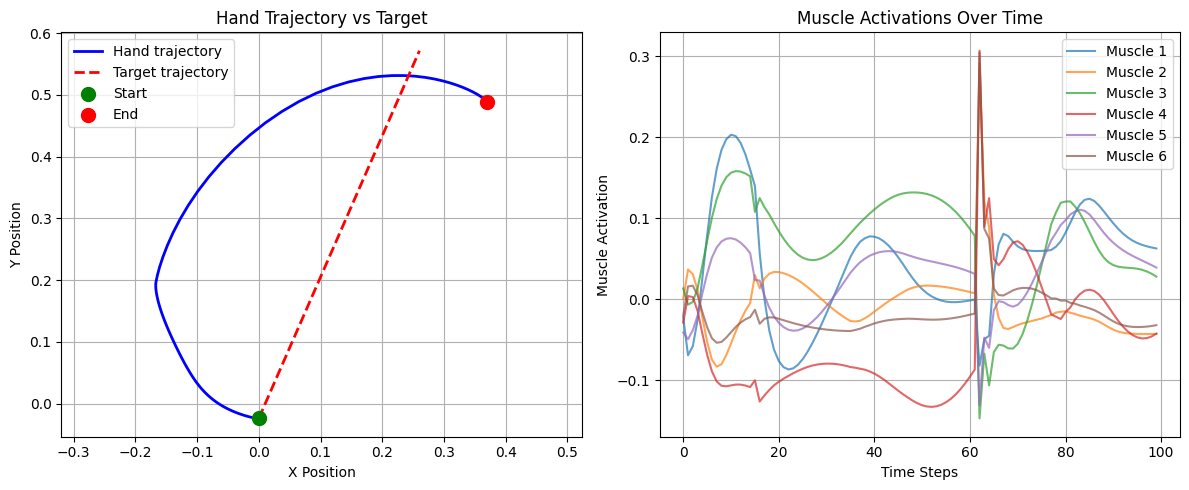


Performance Metrics:
Final position error: 0.1376
Mean position error: 0.1617


In [35]:
import torch
import numpy as np

# Load your pretrained model
with open("models_randtarg500_noforcefield/model.pkl", "rb") as f:
    pretrained_model = pickle.load(f)
    
model = pretrained_model.model
model.eval()

# Generate test trials
#change environment to centre out
test_env_co = RandomTargetCenterOut(
    effector=RigidTendonArm26(muscle=MujocoHillMuscle(),pos_lower_bound=[-20, -20], pos_upper_bound=[20,20]),)
test_env_co.skeleton.l2=test_env_co.skeleton.l1
# Generate a dataset with your trials
test_dataset = test_env_co.generate_dataset(n_samples=10)
trial_idx = 0  # Pick the first trial

# Extract trial data
ics = test_dataset[0]["ics"][trial_idx:trial_idx+1]  # Shape: (1, 4)
inputs = test_dataset[0]["inputs"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 3)
targets = test_dataset[0]["targets"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 2)
inputs_to_env = test_dataset[0]["inputs_to_env"][trial_idx:trial_idx+1]  # Shape: (1, n_timesteps, 2)

print(f"  ICS: {ics}")
print(f"Trial shapes:")
print(f"  ICs: {ics.shape}")
print(f"  Inputs: {inputs.shape}")
print(f"  Targets: {targets.shape}")
print(f"  Env inputs: {inputs_to_env.shape}")

# Reset environment with the trial's initial conditions
obs, info = test_env_co.reset(
    batch_size=1,
    options={"ic_state": ics, "deterministic": True}
)

n_timesteps = inputs.shape[1]
print(n_timesteps)
trajectory = []
hidden = None

print(f"Starting trial simulation...")
print(f"Initial observation shape: {obs.shape}")
print(f"Expected: (1, 14) -> vision(2) + proprioception(12)")

# Run the trial step by step
for t in range(n_timesteps):
    # Get current context inputs (TargetX, TargetY, GoCue)
    context_input = torch.tensor(inputs[0, t:t+1, :], dtype=torch.float32)  # Shape: (1, 3)
    
    # Combine observation with context inputs to get full model input
    full_input = torch.cat([obs, context_input], dim=-1)  # Shape: (1, 17)
    
    print(f"Step {t}: obs shape {obs.shape}, context shape {context_input.shape}, full input shape {full_input.shape}")
    
    # Forward pass through model
    with torch.no_grad():
        action_pred, hidden = model(full_input, hidden)
    
    # Extract muscle activations (first 6 outputs)
    muscle_activations = action_pred[:, :test_env_co.action_space.shape[0]]
    
    # Apply force field if needed (pass env inputs as endpoint_load)
    #try removing this line if not using force field
    env_force = torch.tensor(inputs_to_env[0, t:t+1, :], dtype=torch.float32)
    
    # Step the environment
    #also update this call to not use the endpoint load
    obs, _, done, _, info = test_env_co.step(
        muscle_activations, 
        deterministic=True,
        endpoint_load=env_force
    )
    
    # Store trajectory data
    trajectory.append({
        'timestep': t,
        'context_input': context_input.squeeze().cpu().numpy(),
        'observation': obs.squeeze().cpu().numpy(),
        'action': muscle_activations.squeeze().cpu().numpy(),
        'fingertip_pos': info['states']['fingertip'].squeeze().cpu().numpy(),
        'target_pos': targets[0, t, :].cpu().numpy(),
        'force_applied': env_force.squeeze().cpu().numpy()
    })
    
    if done:
        print(f"Trial ended at timestep {t}")
        break

print(f"Trial completed with {len(trajectory)} timesteps")

# Plot the results
import matplotlib.pyplot as plt

# Extract trajectory data for plotting
fingertip_positions = np.array([step['fingertip_pos'] for step in trajectory])
target_positions = np.array([step['target_pos'] for step in trajectory])
actions = np.array([step['action'] for step in trajectory])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot hand trajectory vs target
ax1.plot(fingertip_positions[:, 0], fingertip_positions[:, 1], 'b-', label='Hand trajectory', linewidth=2)
ax1.plot(target_positions[:, 0], target_positions[:, 1], 'r--', label='Target trajectory', linewidth=2)
ax1.scatter(fingertip_positions[0, 0], fingertip_positions[0, 1], c='green', s=100, label='Start', zorder=5)
ax1.scatter(fingertip_positions[-1, 0], fingertip_positions[-1, 1], c='red', s=100, label='End', zorder=5)
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_title('Hand Trajectory vs Target')
ax1.legend()
ax1.grid(True)
ax1.axis('equal')

# Plot muscle activations over time
for i in range(6):
    ax2.plot(actions[:, i], label=f'Muscle {i+1}', alpha=0.7)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Muscle Activation')
ax2.set_title('Muscle Activations Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate performance metrics
final_error = np.linalg.norm(fingertip_positions[-1] - target_positions[-1])
mean_error = np.mean([np.linalg.norm(fp - tp) for fp, tp in zip(fingertip_positions, target_positions)])

print(f"\nPerformance Metrics:")
print(f"Final position error: {final_error:.4f}")
print(f"Mean position error: {mean_error:.4f}")